#Baseline Models : Synthetic 2nd dataset

In this notebook we applied all baseline models on the synthetic 2nd dataset to generated the predicted summary and full causal graphs.

In [ ]:
import numpy as np
import pandas as pd

data = pd.read_csv('/content/synthetic_2nd_dataset.csv')

In [ ]:
data.iloc[0:5,:]

,S1,S2,S3,S4,noise1,noise2,noise3,noise4
0,8.913554,0.000000,0.000000,0.000000,-1.086446,-0.783978,0.961988,-0.680052
1,9.103935,0.864968,0.931469,9.985518,-0.896065,0.864968,0.931469,-0.014482
2,9.693701,0.220185,-0.186650,10.338397,-0.306299,0.220185,-0.186650,0.338397
3,-1.339934,-0.060682,0.493351,3.208927,-1.339934,-0.060682,0.493351,0.899508
4,-1.206586,1.666979,-3.916721,2.004742,-1.206586,2.331208,-1.858839,0.782074


In [ ]:
true_graph = np.zeros((4,4))
true_graph[0,0]=1
true_graph[0,1]=1
true_graph[0,2]=1
true_graph[0,3]=1
true_graph[2,3]=1
true_graph[3,3]=1
true_graph

array([[1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
true_full_graph = np.zeros((4,24))
true_full_graph[0,0]=1
true_full_graph[0,12]=1
true_full_graph[1,16]=1
true_full_graph[2,16]=1
true_full_graph[3,16]=1
true_full_graph[3,18]=1
true_full_graph[3,19]=1
true_full_graph

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 1., 0., 0., 0., 0.]])

In [ ]:
!pip install cdt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.1/921.1 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=6c25e1b4bcf186243c5d7d7a4a28dd4e36900b15f16f5f6e75fd69387a83cd07
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=29dda252c0f6d99a22d3f238a0f8f0683cd1a3800fa24b2a063b7db0b1549c70
  Stored in directory: /root/.cache/pip/wheels/dd/67/40/683074a684607162bd0e34dcf7ccdfcab5861c3b2a83286f3a
Successfully built GPUtil skrebate


In [ ]:
import cdt

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


#Data Pre-processing

In [ ]:
import numpy as np
import pandas as pd

def data_preprocessing(data, max_lag=5):
  from sklearn.preprocessing import MinMaxScaler

  #convert to numpy array
  syn_data_np = data.to_numpy()

  #normalize the dataset
  scaler_X = MinMaxScaler(feature_range=(0, 1))
  syn_data_np_nor = scaler_X.fit_transform(syn_data_np)
  syn_data_np = syn_data_np_nor

  #transform into 2D data
  syn_data_np_T= syn_data_np.T
  syn_data_pro = np.zeros((syn_data_np.shape[0]-max_lag,syn_data_np.shape[1],(max_lag+1)))
  for i in range(0, (syn_data_np.shape[0]-max_lag)):
    syn_data_pro[i,:,:]= syn_data_np_T[:, i:i+(max_lag+1)]
  syn_data_2d = np.expand_dims(syn_data_pro, axis =-1)

  #make datafrom with normalized data
  syn_data_nor_df =pd.DataFrame(data = syn_data_np,
                  columns = data.columns)

  #transform normalized data into 1D shape with lagged and current time values
  size_1d = syn_data_np.shape[1]*(max_lag+1)
  print(size_1d)
  syn_data_1d = np.zeros((syn_data_np.shape[0]-max_lag,size_1d))
  for i in range(0, (syn_data_np.shape[0]-max_lag)):
    for j in range(0,(max_lag+1)):
      j_end = j * syn_data_np.shape[1]
      syn_data_1d[i,j_end:j_end+syn_data_np.shape[1]]= syn_data_np[i+j, :]

  #transform non-normalized data into 1D shape with lagged and current time values
  syn_data_np_2 = data.to_numpy()
  syn_data_1d_not_norm = np.zeros((syn_data_np_2.shape[0]-max_lag,size_1d))
  for i in range(0, (syn_data_np_2.shape[0]-max_lag)):
    for j in range(0,(max_lag+1)):
      j_end = j * syn_data_np_2.shape[1]
      syn_data_1d_not_norm[i,j_end:j_end+syn_data_np_2.shape[1]]= syn_data_np_2[i+j, :]


  return syn_data_np_nor, syn_data_2d, syn_data_nor_df, syn_data_1d,  syn_data_1d_not_norm

In [ ]:
syn_data_np, syn_data_2d, syn_data_nor_df, syn_data_1d, syn_data_1d_nn = data_preprocessing(data.iloc, max_lag=5)

24


In [ ]:
syn_data_2d.shape

(99995, 4, 6, 1)

In [ ]:
syn_data_np.shape

(100000, 4)

In [ ]:
syn_data_nor_df.shape

(100000, 4)

In [ ]:
syn_data_1d.shape

(99995, 24)

In [ ]:
syn_data_1d_nn.shape

(99995, 24)

#DAG-GNN Model

We have used the code provided by the authors of the DAG-GNN model and modified the main method to apply our synthetic dataset.

In [ ]:
%cd /content

/content


In [ ]:
! git clone https://github.com/fishmoon1234/DAG-GNN

Cloning into 'DAG-GNN'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 52 (delta 0), reused 4 (delta 0), pack-reused 43
Receiving objects: 100% (52/52), 34.39 KiB | 550.00 KiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
!mkdir /content/DAG-GNN/data

In [ ]:
syn_data_1d_nn_df = pd.DataFrame(syn_data_1d_nn[:50000,:]) #syn_data_1d[:50000,:]

In [ ]:
syn_data_1d_nn_df.to_csv('/content/DAG-GNN/data/synthetic_data_1D_24.csv', index=False)

In [ ]:
%cd DAG-GNN/src/

/content/DAG-GNN/src


In [ ]:
%%python train.py --filename=synthetic_data_1D_24 --epochs=20

Namespace(data_type='synthetic', data_filename='alarm', data_dir='data/', data_sample_size=5000, data_variable_size=100, graph_type='erdos-renyi', graph_degree=3, graph_sem_type='linear-gauss', graph_linear_type='nonlinear_2', edge_types=2, x_dims=1, z_dims=1, optimizer='Adam', graph_threshold=0.3, tau_A=0.0, lambda_A=0.0, c_A=1, use_A_connect_loss=0, use_A_positiver_loss=0, no_cuda=False, seed=42, epochs=20, batch_size=100, lr=0.003, encoder_hidden=64, decoder_hidden=64, temp=0.5, k_max_iter=100.0, encoder='mlp', decoder='mlp', no_factor=False, suffix='_springs5', encoder_dropout=0.0, decoder_dropout=0.0, save_folder='logs', filename='synthetic_data_1D_24', load_folder='', h_tol=1e-08, prediction_steps=10, lr_decay=200, gamma=1.0, skip_first=False, var=5e-05, hard=False, prior=False, dynamic_graph=False, sea_ice=True, cuda=False, factor=True)
:::: @dv: shape of dataset = (50001, 24, 1)::::
0.014537189128578376
Epoch: 0000 nll_train: 0.0336290450 kl_train: 0.0151151371 ELBO_loss: 0.048

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


DAG-GNN model stores the predicted causal graphs inside the "src" directory of the code base with a file name "predG". We have to read that file to plot the predicted causal graph

In [ ]:
adja_mat = np.loadtxt('/content/DAG-GNN/src/synthetic_data_1D_24__tauA0.0__thresh0.3/predG')

In [ ]:
adja_mat.shape

(24, 24)

In [ ]:
mat_syn_df = pd.DataFrame(adja_mat[:,20:])

In [ ]:
mat_syn_df

,0,1,2,3
0,-0.00000,0.00014,-0.00002,0.00003
1,0.00041,0.00203,0.00016,0.00184
2,-0.00000,0.00001,-0.00001,-0.00000
3,0.00001,0.00000,-0.00002,-0.00011
4,0.00001,0.00018,0.00000,0.00004
5,0.00010,0.00029,-0.00000,0.00012
6,-0.00000,0.00020,0.00003,0.00010
7,0.00001,-0.00003,0.00005,0.00084
8,0.13055,0.00003,-0.00000,-0.00000
9,0.00048,0.00108,0.00002,0.00075


In [ ]:
matrix_2d_syn = adja_mat[:,20:]

## Full Causal Graph

In [ ]:
import networkx as nx
G_1 = nx.DiGraph()

nodes_1 = ["S1(t-5)", "S2(t-5)", "S3(t-5)",  "S4(t-5)",
         "S1(t-4)", "S2(t-4)", "S3(t-4)",  "S4(t-4)",
         "S1(t-3)", "S2(t-3)", "S3(t-3)",  "S4(t-3)",
         "S1(t-2)", "S2(t-2)", "S3(t-2)",  "S4(t-2)",
         "S1(t-1)", "S2(t-1)", "S3(t-1)",  "S4(t-1)",
         "S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
nodes_r_1=["S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
edges_1 = []
pred_graph_dag_f = np.zeros((4,24))

In [ ]:
for i in range (0, 24):
  G_1.add_node(nodes_1[i],pos=(int(i/4)+1,(i%4)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_syn[i,j] > 0.1:
      print(i,j)
      G_1.add_edge(nodes_1[i], nodes_r_1[j], weight=i)
      pred_graph_dag_f[j,i]=1


8 0
21 3
23 2


In [ ]:
pos_1=nx.get_node_attributes(G_1,'pos')
pos_1

{'S1(t-5)': (1, 1),
 'S2(t-5)': (1, 2),
 'S3(t-5)': (1, 3),
 'S4(t-5)': (1, 4),
 'S1(t-4)': (2, 1),
 'S2(t-4)': (2, 2),
 'S3(t-4)': (2, 3),
 'S4(t-4)': (2, 4),
 'S1(t-3)': (3, 1),
 'S2(t-3)': (3, 2),
 'S3(t-3)': (3, 3),
 'S4(t-3)': (3, 4),
 'S1(t-2)': (4, 1),
 'S2(t-2)': (4, 2),
 'S3(t-2)': (4, 3),
 'S4(t-2)': (4, 4),
 'S1(t-1)': (5, 1),
 'S2(t-1)': (5, 2),
 'S3(t-1)': (5, 3),
 'S4(t-1)': (5, 4),
 'S1(t)': (6, 1),
 'S2(t)': (6, 2),
 'S3(t)': (6, 3),
 'S4(t)': (6, 4)}

In [ ]:
weights_1 = nx.get_edge_attributes(G_1,'weight').values()

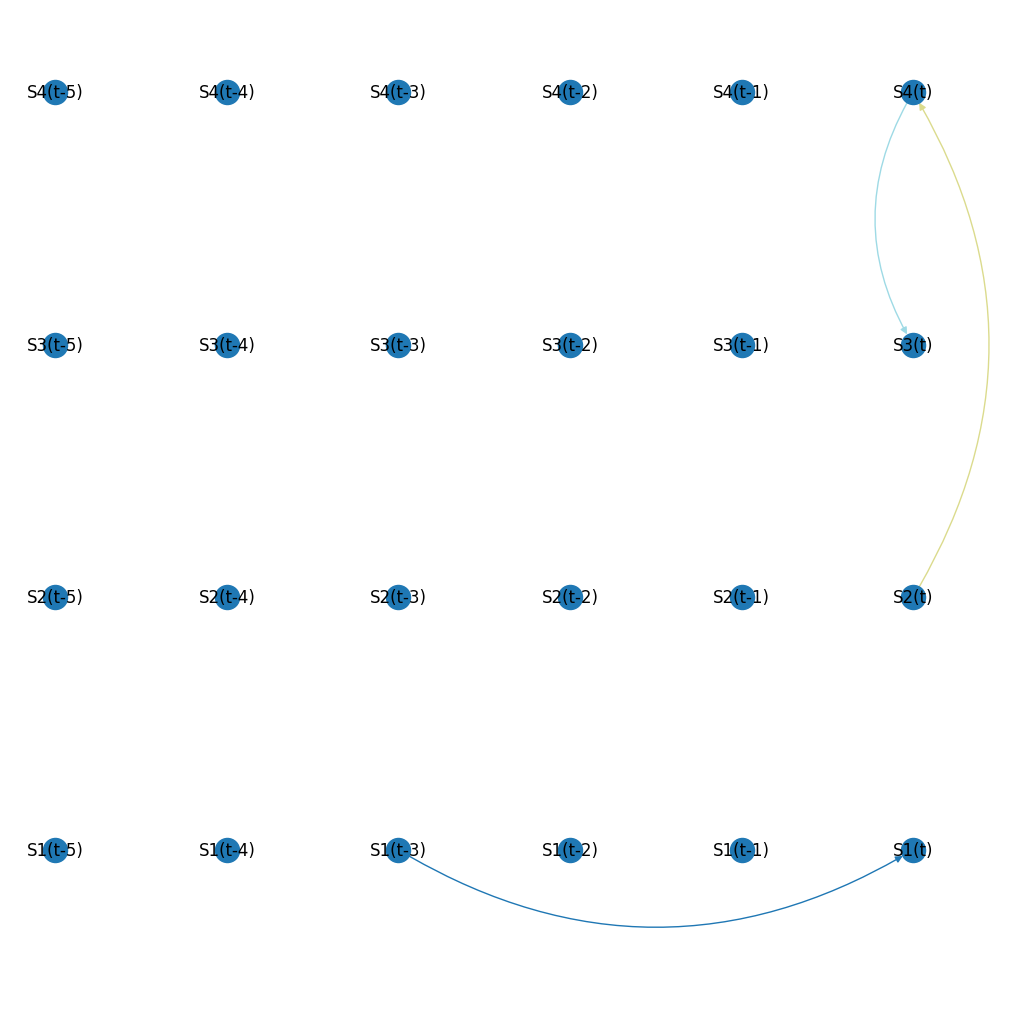

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
nx.draw(G_1, pos_1, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_1, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

In [ ]:
cdt.metrics.SHD(true_full_graph, pred_graph_dag_f)

10.0

In [ ]:
true_values = true_full_graph
predictions = pred_graph_dag_f

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.8958333333333334, Precision: 0.0, Recall: 0.0, FDR: 1.0, F1 Score: nan


invalid value encountered in double_scalars


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_full_graph.reshape(-1), pred_graph_dag_f.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_full_graph.reshape(-1), pred_graph_dag_f.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_full_graph.reshape(-1), pred_graph_dag_f.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_full_graph.reshape(-1), pred_graph_dag_f.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.8958333333333334
Precision: 0.0
Recall (Sensitivity): 0.0
F1-Score: 0.0


##Summary Graph

In [ ]:
import networkx as nx
G_1_s = nx.DiGraph()

nodes_1_s = ["S1", "S2", "S3",  "S4"]
nodes_r_1_s=["S1", "S2", "S3",  "S4"]
pred_graph_1_s = np.zeros((4,4))

In [ ]:
for i in range (0, 4):
  G_1_s.add_node(nodes_1_s[i],pos=(int(i/2)+1,(i%2)+1))

In [ ]:
# for i in range(0, 30):
#   for j in range (0, 5):
#     if matrix_2d[j,i] > 0.30:
#       print(i,j)
#       G.add_edge(nodes[i%5], nodes_r[j], weight=i)

for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_syn[i,j] > 0.1:
      print(i,j)
      G_1_s.add_edge(nodes_1_s[i%4], nodes_r_1_s[j], weight=i)
      pred_graph_1_s[i%4, j]=1


8 0
21 3
23 2


In [ ]:
pos_1_s=nx.get_node_attributes(G_1_s,'pos')
pos_1_s

{'S1': (1, 1), 'S2': (1, 2), 'S3': (2, 1), 'S4': (2, 2)}

In [ ]:
weights_1_s = nx.get_edge_attributes(G_1_s,'weight').values()

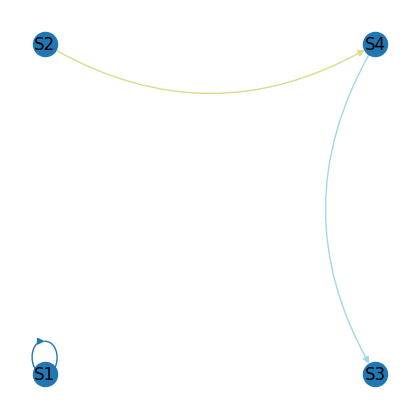

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))

nx.draw(G_1_s, pos_1_s, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_1_s, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

In [ ]:
pred_graph_1_s

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [ ]:
cdt.metrics.SHD(true_graph, pred_graph_1_s)

7.0

In [ ]:
true_values = true_graph
predictions = pred_graph_1_s

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.5625, Precision: 0.3333333333333333, Recall: 0.16666666666666666, FDR: 0.6666666666666666, F1 Score: 0.2222222222222222


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_graph.reshape(-1), pred_graph_1_s.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_graph.reshape(-1), pred_graph_1_s.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_graph.reshape(-1), pred_graph_1_s.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_graph.reshape(-1), pred_graph_1_s.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.5625
Precision: 0.3333333333333333
Recall (Sensitivity): 0.16666666666666666
F1-Score: 0.2222222222222222


# PCMCI Method

The following code blocks installed the PCMCI and PCMCI+ methods from the "https://github.com/jakobrunge/tigramite" GitHub repository. This is the main code repository maintained by the author Jakob Runge.

In [ ]:
#!pip install graphviz
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 2.24.33-2ubuntu2 [15.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64

In [ ]:
#Importing common packages
import os
import math
import glob
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import seaborn as sns
import random
import matplotlib.pyplot as plt
#Importing packages for graph generation
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
#Importing packages for Granger Causality
from dateutil.parser import parse
from scipy import signal
from scipy.interpolate import interp1d
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

#Importing packages for PCMCI

In [ ]:
#Restart runtime after successfully running this cell

!pip install dcor
!pip install matplotlib --upgrade
#!pip install tigramite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
! git clone https://github.com/jakobrunge/tigramite

Cloning into 'tigramite'...
remote: Enumerating objects: 7044, done.
remote: Counting objects: 100% (2021/2021), done.
remote: Compressing objects: 100% (674/674), done.
remote: Total 7044 (delta 1407), reused 1692 (delta 1341), pack-reused 5023
Receiving objects: 100% (7044/7044), 85.06 MiB | 18.88 MiB/s, done.
Resolving deltas: 100% (4796/4796), done.


In [ ]:
%cd tigramite

/content/tigramite


In [ ]:
!python setup.py install

/usr/local/lib/python3.10/dist-packages/setuptools/dist.py:755: SetuptoolsDeprecationWarning: Invalid dash-separated options
!!

        ********************************************************************************
        Usage of dash-separated 'description-file' will not be supported in future
        versions. Please use the underscore name 'description_file' instead.

        This deprecation is overdue, please update your project and remove deprecated
        calls to avoid build errors in the future.

        See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
        ********************************************************************************

!!
  opt = self.warn_dash_deprecation(opt, section)
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
 

In [ ]:
# Imports
import numpy as np
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI
from tigramite.independence_tests.parcorr import ParCorr #, GPDC, CMIknn, CMIsymb

from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI

In [ ]:
syn_data_4_df.columns

Index(['S1', 'S2', 'S3', 'S4'], dtype='object')

##Create and apply the PCMCI model

In [ ]:
# copy variable names from headlines to define dataframe
var_name = ['S1', 'S2', 'S3', 'S4']
np_features = syn_data_4_df.to_numpy()

df_all_data_v = pp.DataFrame(np_features, var_names = var_name)

In [ ]:
parcorr = ParCorr(significance='analytic')
#pcmci = PCMCI(dataframe=df_all_data_v, cond_ind_test=RobustParCorr(), verbosity = 1)
pcmci = PCMCI(
    dataframe=df_all_data_v,
    cond_ind_test=parcorr,
    verbosity=1)

tau_max = 5
pc_alpha = 0.1
alpha_level = 0.01
results_pcmci = pcmci.run_pcmci(tau_max = tau_max, pc_alpha = None, alpha_level = alpha_level)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable S1 has 14 link(s):
    [pc_alpha = 0.5]
        (S3 -1): max_pval = 0.00000, |min_val| =  0.338
        (S3 -4): max_pval = 0.00000, |min_val| =  0.292
        (S1 -5): max_pval = 0.00000, |min_val| =  0.091
        (S1 -2): max_pval = 0.00000, |min_val| =  0.087
        (S1 -3): max_pval = 0.00000, |min_val| =  0.083
        (S4 -4): max_pval = 0.00000, |min_val| =  0.066
        (S3 -3): max_pval = 0.00000, |min_val| =  0.019
        (S1 -4): max_pval = 0.00000, |min_val| =  0.017
        (S4 -1): max_pval = 0.00111, |min_val| =  0.010
        (S3 -2): max_pval = 0.02346, |min_val| =  0.007
        (S2 -2): max_pval = 0.02454, |min_val| =  0.007
        (S4 -2): max_pval = 0.35244, |min_val| =  0.003
        (S3 -5):

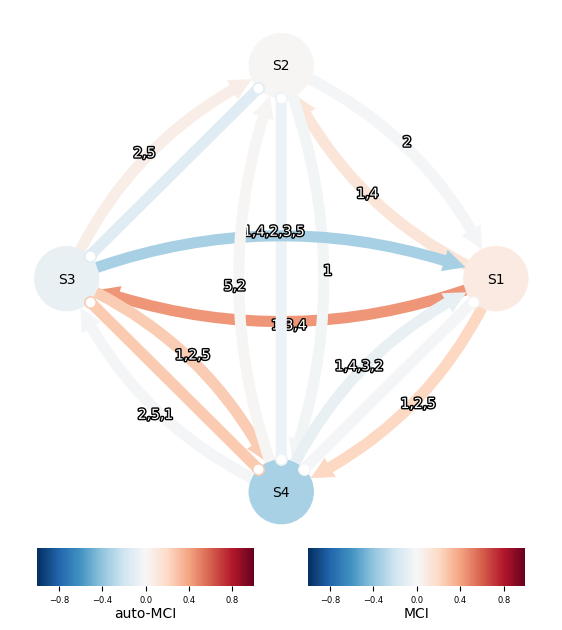

In [ ]:
tp.plot_graph(graph=results_pcmci['graph'],
              val_matrix=results_pcmci['val_matrix'],
              var_names = var_name,
              figsize = (7,7))
plt.show()

## Full Causal Graph

In [ ]:
results_pcmci['graph']

array([[['', '-->', '-->', '-->', '', '-->'],
        ['', '-->', '', '', '-->', ''],
        ['', '-->', '', '-->', '-->', ''],
        ['o-o', '-->', '-->', '', '', '-->']],

       [['', '', '-->', '', '', ''],
        ['', '', '', '', '', '-->'],
        ['o-o', '', '', '', '', ''],
        ['o-o', '-->', '', '', '', '']],

       [['', '-->', '-->', '-->', '-->', '-->'],
        ['o-o', '', '-->', '', '', '-->'],
        ['', '', '-->', '', '', '-->'],
        ['o-o', '-->', '-->', '', '', '-->']],

       [['o-o', '-->', '-->', '-->', '-->', ''],
        ['o-o', '', '-->', '', '', '-->'],
        ['o-o', '-->', '-->', '', '', '-->'],
        ['', '-->', '', '-->', '', '-->']]], dtype='<U3')

In [ ]:
pcmci_res = results_pcmci['graph']
pcmci_full_graph = np.zeros((4,24))
for i in range(0, 4):
  for j in range (0, 4):
    for l in range (0, 6):
      if pcmci_res[i,j,l] == '-->' or pcmci_res[i,j,l] == '<--':
        k = i +4*(5-l)
        pcmci_full_graph[j,k]=1

In [ ]:
matrix_2d_2d = pcmci_full_graph

In [ ]:
np.savetxt('pcmci-full-adj-mat-D2.csv', matrix_2d_2d, delimiter=",")

In [ ]:
import networkx as nx
G_2d = nx.DiGraph()

nodes_2d = ["S1(t-5)", "S2(t-5)", "S3(t-5)",  "S4(t-5)",
         "S1(t-4)", "S2(t-4)", "S3(t-4)",  "S4(t-4)",
         "S1(t-3)", "S2(t-3)", "S3(t-3)",  "S4(t-3)",
         "S1(t-2)", "S2(t-2)", "S3(t-2)",  "S4(t-2)",
         "S1(t-1)", "S2(t-1)", "S3(t-1)",  "S4(t-1)",
         "S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
nodes_r_2d=["S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
edges_2d = []


In [ ]:
for i in range (0, 24):
  G_2d.add_node(nodes_2d[i],pos=(int(i/4)+1,(i%4)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d[j,i] > 0.2:
      #print(i,j)
      G_2d.add_edge(nodes_2d[i], nodes_r_2d[j], weight=i)


In [ ]:
pos_2d=nx.get_node_attributes(G_2d,'pos')
#pos_2d

In [ ]:
weights_2d = nx.get_edge_attributes(G_2d,'weight').values()

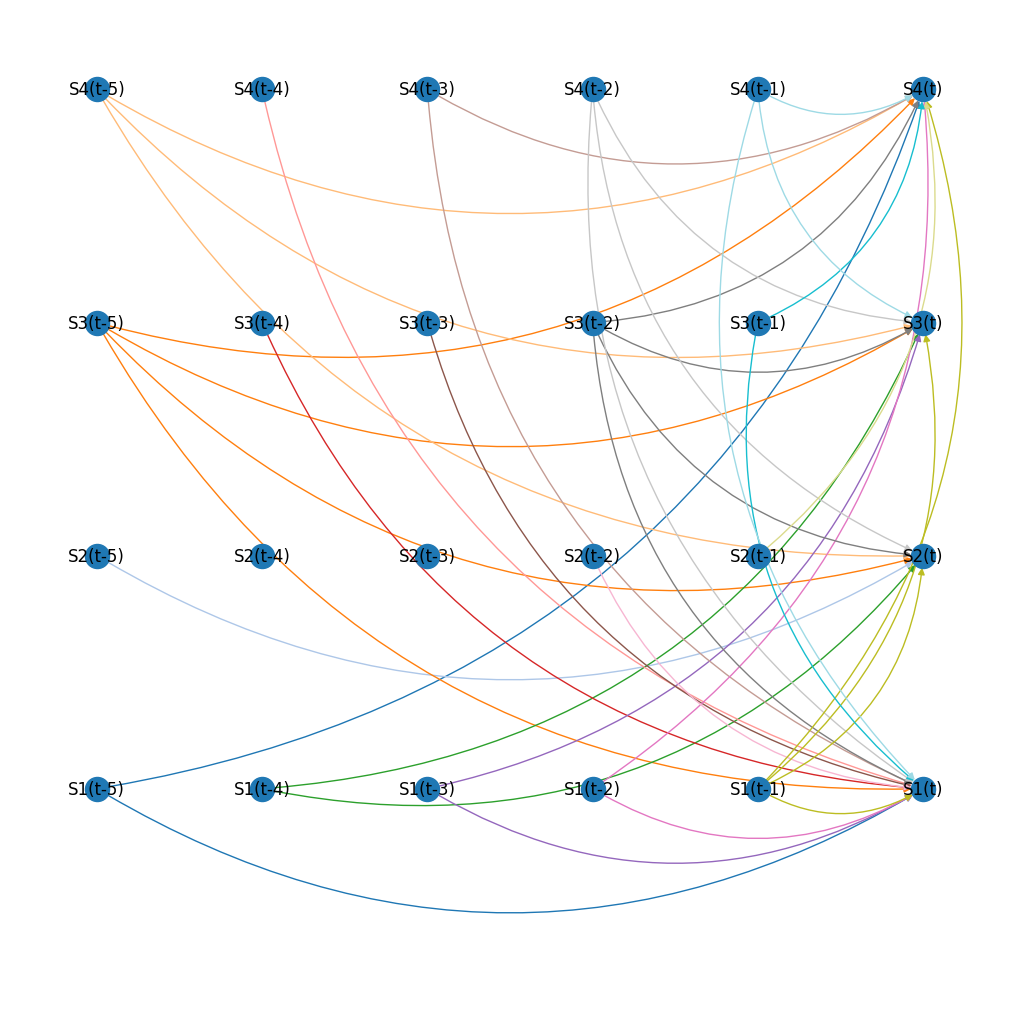

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
nx.draw(G_2d, pos_2d, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_2d, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

In [ ]:
cdt.metrics.SHD(true_full_graph, pcmci_full_graph)

32.0

In [ ]:
true_values = true_full_graph
predictions = pcmci_full_graph

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.6666666666666666, Precision: 0.1794871794871795, Recall: 1.0, FDR: 0.8205128205128205, F1 Score: 0.30434782608695654


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_full_graph.reshape(-1), pcmci_full_graph.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_full_graph.reshape(-1), pcmci_full_graph.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_full_graph.reshape(-1), pcmci_full_graph.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_full_graph.reshape(-1), pcmci_full_graph.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.6666666666666666
Precision: 0.1794871794871795
Recall (Sensitivity): 1.0
F1-Score: 0.30434782608695654


##Summary Causal Graph

In [ ]:
import networkx as nx
G_2d_1 = nx.DiGraph()

nodes_2d_1 = ["S1", "S2", "S3",  "S4"]
nodes_r_2d_1= ["S1", "S2", "S3",  "S4"]
edges_2d_1 = []
pred_graph_2 = np.zeros((4,4))

In [ ]:
for i in range (0, 4):
  G_2d_1.add_node(nodes_2d_1[i],pos=(int(i/2)+1,(i%2)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d[j,i] > 0.2:
      #print(i,j)
      G_2d_1.add_edge(nodes_2d_1[i%4], nodes_r_2d_1[j], weight=i)
      pred_graph_2[i%4, j]=1


In [ ]:
pos_2d_1=nx.get_node_attributes(G_2d_1,'pos')
pos_2d_1

{'S1': (1, 1), 'S2': (1, 2), 'S3': (2, 1), 'S4': (2, 2)}

In [ ]:
weights_2d_1 = nx.get_edge_attributes(G_2d_1,'weight').values()

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


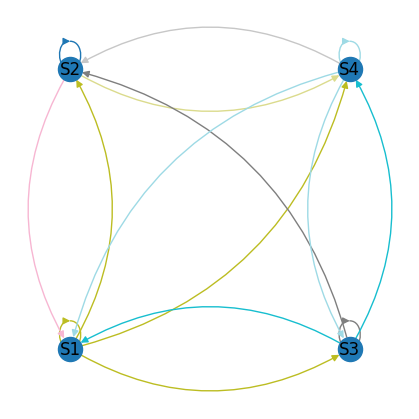

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
nx.draw(G_2d_1, pos_2d_1, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_2d_1, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

In [ ]:
pred_graph_2

array([[1., 1., 1., 1.],
       [1., 1., 0., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [ ]:
np.savetxt('pcmci-summary-adj-mat-D2.csv', pred_graph_2, delimiter=",")

In [ ]:
cdt.metrics.SHD(true_graph, pred_graph_2)

9.0

In [ ]:
true_values = true_graph
predictions = pred_graph_2

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.4375, Precision: 0.4, Recall: 1.0, FDR: 0.6, F1 Score: 0.5714285714285715


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_graph.reshape(-1), pred_graph_2.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_graph.reshape(-1), pred_graph_2.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_graph.reshape(-1), pred_graph_2.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_graph.reshape(-1), pred_graph_2.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.4375
Precision: 0.4
Recall (Sensitivity): 1.0
F1-Score: 0.5714285714285715


# PCMCI+ Method

To apply the PCMCI+ method on the dataset first we have to execute the PCMCI method. Then we have to call the PCMCI+ method using the same instance object the main "pcmci" class.

In [ ]:
results_plus = pcmci.run_pcmciplus(tau_max = tau_max, pc_alpha = None)


##
## Optimizing pc_alpha over pc_alpha_list = [0.001, 0.005, 0.01, 0.025, 0.05]
##

## pc_alpha = 0.001 (1/5):

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.001]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable S1 has 9 link(s):
        (S3 -1): max_pval = 0.00000, |min_val| =  0.365
        (S3 -4): max_pval = 0.00000, |min_val| =  0.295
        (S1 -2): max_pval = 0.00000, |min_val| =  0.093
        (S1 -5): max_pval = 0.00000, |min_val| =  0.091
        (S1 -3): max_pval = 0.00000, |min_val| =  0.086
        (S4 -4): max_pval = 0.00000, |min_val| =  0.068
        (S4 -2): max_pval = 0.00000, |min_val| =  0.024
        (S3 -3): max_pval = 0.00000, |min_val| =  0.021
        (S1 -4): max_pval = 0.00000, |min_val| =  0.018

    Variable S2 has 4 link(s):
        (S1 -1): max_pval = 0.00000, |min_val| =  0.060
        (S3 -5): max_pval = 0

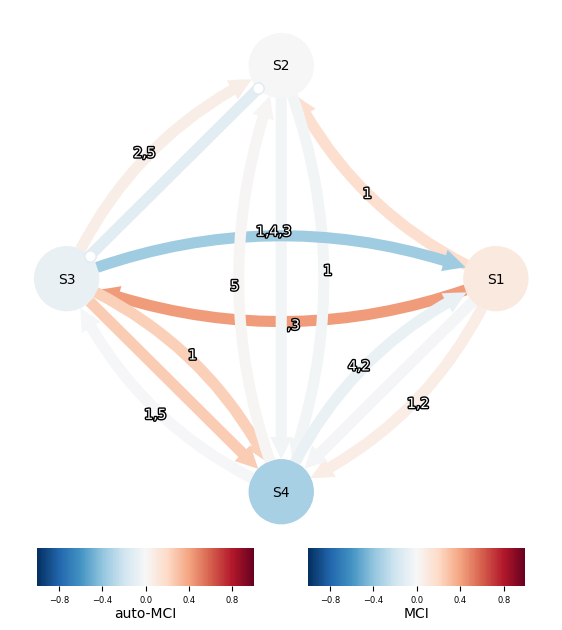

In [ ]:
tp.plot_graph(graph=results_plus['graph'],
              val_matrix=results_plus['val_matrix'],
              var_names = var_name,
              figsize = (7,7))
plt.show()

##Full Causal Graph

In [ ]:
results_plus['graph']

array([[['', '', '-->', '-->', '', '-->'],
        ['', '-->', '', '', '', ''],
        ['', '-->', '', '-->', '', ''],
        ['-->', '-->', '-->', '', '', '']],

       [['', '', '', '', '', ''],
        ['', '', '', '', '', ''],
        ['o-o', '', '', '', '', ''],
        ['-->', '-->', '', '', '', '']],

       [['', '-->', '', '-->', '-->', ''],
        ['o-o', '', '-->', '', '', '-->'],
        ['', '', '-->', '', '', '-->'],
        ['-->', '-->', '', '', '', '']],

       [['<--', '', '-->', '', '-->', ''],
        ['<--', '', '', '', '', '-->'],
        ['<--', '-->', '', '', '', '-->'],
        ['', '-->', '', '-->', '', '']]], dtype='<U3')

In [ ]:
results_plus['graph'].shape

(4, 4, 6)

In [ ]:
pcmci_plus = results_plus['graph']
pcmci_plus_full_graph = np.zeros((4,24))
for i in range(0, 4):
  for j in range (0, 4):
    for l in range (0, 6):
      if pcmci_plus[i,j,l] == '-->' or pcmci_plus[i,j,l] == '<--':
        k = i +4*(5-l)
        pcmci_plus_full_graph[j,k]=1

In [ ]:
pcmci_plus_full_graph

array([[1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 0.]])

In [ ]:
np.savetxt('pcmci-plus-full-adj-mat-D2.csv', pcmci_plus_full_graph, delimiter=",")

In [ ]:
matrix_2d_2d_s = pcmci_plus_full_graph

In [ ]:
import networkx as nx
G_2d_s = nx.DiGraph()

nodes_2d_s = ["S1(t-5)", "S2(t-5)", "S3(t-5)",  "S4(t-5)",
         "S1(t-4)", "S2(t-4)", "S3(t-4)",  "S4(t-4)",
         "S1(t-3)", "S2(t-3)", "S3(t-3)",  "S4(t-3)",
         "S1(t-2)", "S2(t-2)", "S3(t-2)",  "S4(t-2)",
         "S1(t-1)", "S2(t-1)", "S3(t-1)",  "S4(t-1)",
         "S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
nodes_r_2d_s=["S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
edges_2d = []


In [ ]:
for i in range (0, 24):
  G_2d_s.add_node(nodes_2d_s[i],pos=(int(i/4)+1,(i%4)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d_s[j,i] > 0.2:
      #print(i,j)
      G_2d_s.add_edge(nodes_2d_s[i], nodes_r_2d_s[j], weight=i)


In [ ]:
pos_2d_s=nx.get_node_attributes(G_2d_s,'pos')
#pos_2d_s

In [ ]:
weights_2d_s = nx.get_edge_attributes(G_2d_s,'weight').values()

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


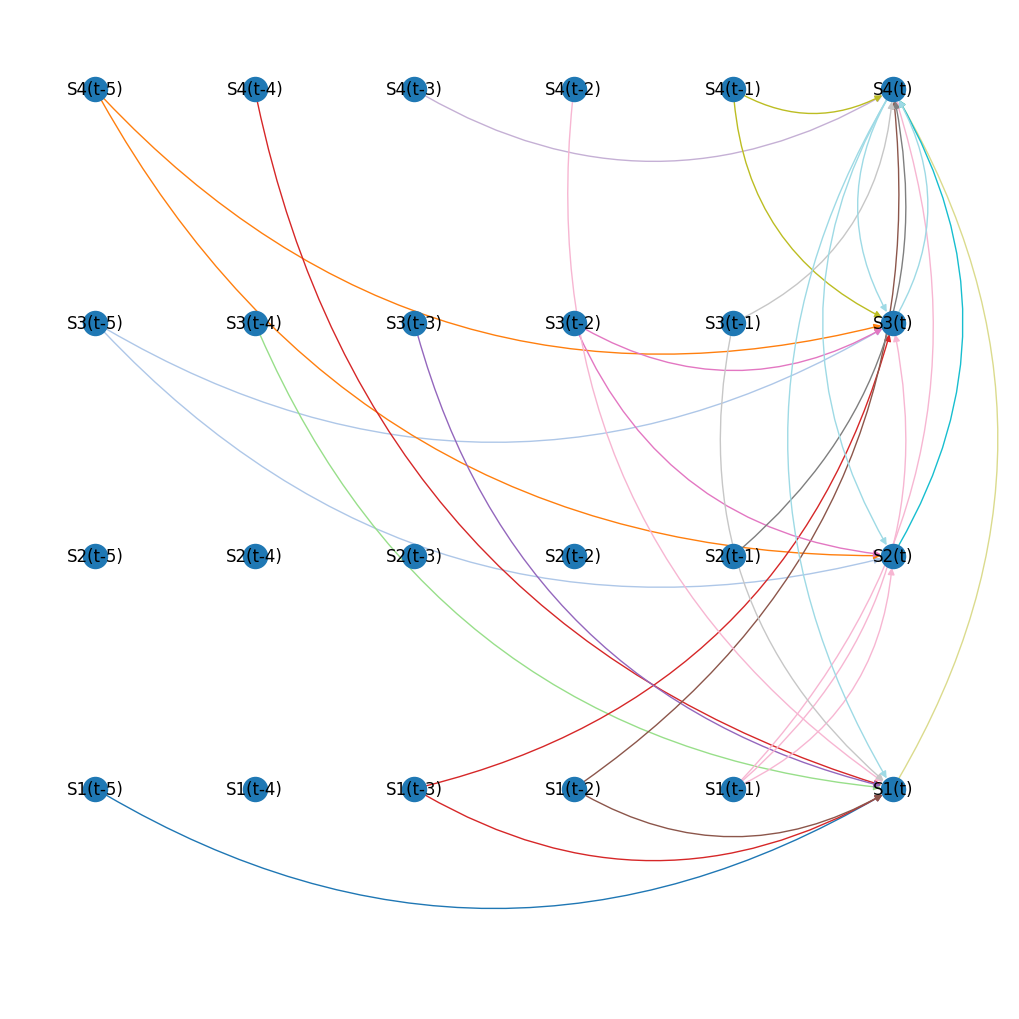

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
nx.draw(G_2d_s, pos_2d_s, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_2d_s, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

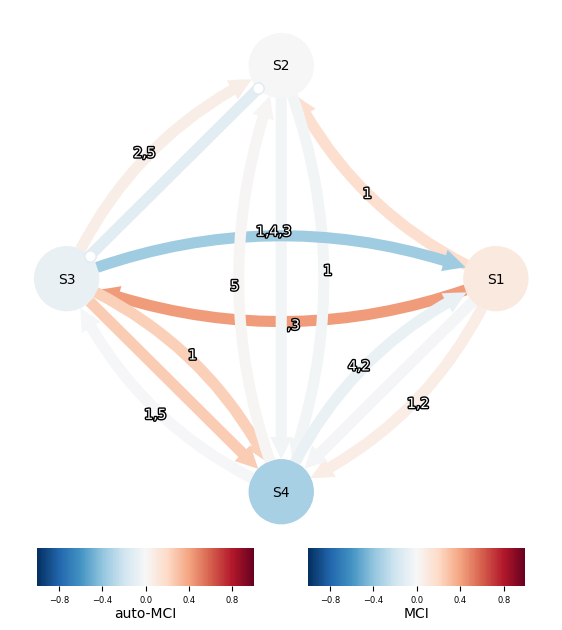

In [ ]:
tp.plot_graph(graph=results_plus['graph'],
              val_matrix=results_plus['val_matrix'],
              var_names = var_name,
              figsize = (7,7))
plt.show()

In [ ]:
cdt.metrics.SHD(true_full_graph, pcmci_plus_full_graph)

23.0

In [ ]:
true_values = true_full_graph
predictions = pcmci_plus_full_graph

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.7604166666666666, Precision: 0.23333333333333334, Recall: 1.0, FDR: 0.7666666666666667, F1 Score: 0.37837837837837834


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_full_graph.reshape(-1), pcmci_plus_full_graph.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_full_graph.reshape(-1), pcmci_plus_full_graph.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_full_graph.reshape(-1), pcmci_plus_full_graph.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_full_graph.reshape(-1), pcmci_plus_full_graph.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.7604166666666666
Precision: 0.23333333333333334
Recall (Sensitivity): 1.0
F1-Score: 0.37837837837837834


##Summary Causal Graph

In [ ]:
import networkx as nx
G_2d_s1 = nx.DiGraph()

nodes_2d_s1 = ["S1", "S2", "S3",  "S4"]
nodes_r_2d_s1= ["S1", "S2", "S3",  "S4"]
edges_2d_s1 = []
pred_graph_s1 = np.zeros((4,4))

In [ ]:
for i in range (0, 4):
  G_2d_s1.add_node(nodes_2d_s1[i],pos=(int(i/2)+1,(i%2)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d_s[j,i] > 0.2:
      #print(i,j)
      G_2d_s1.add_edge(nodes_2d_s1[i%4], nodes_r_2d_s1[j], weight=i)
      pred_graph_s1[i%4, j]=1


In [ ]:
pos_2d_s1=nx.get_node_attributes(G_2d_s1,'pos')
pos_2d_s1

{'S1': (1, 1), 'S2': (1, 2), 'S3': (2, 1), 'S4': (2, 2)}

In [ ]:
weights_2d_s1 = nx.get_edge_attributes(G_2d_s1,'weight').values()

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


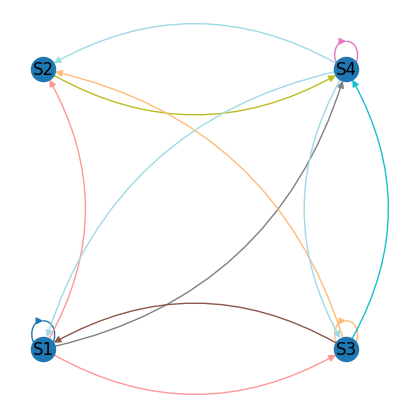

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
nx.draw(G_2d_s1, pos_2d_s1, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_2d_s1, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

In [ ]:
pred_graph_s1

array([[1., 1., 1., 1.],
       [0., 0., 0., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [ ]:
np.savetxt('pcmci-plus-summary-adj-mat-D2.csv', pred_graph_s1, delimiter=",")

In [ ]:
cdt.metrics.SHD(true_graph, pred_graph_s1)

7.0

In [ ]:
true_values = true_graph
predictions = pred_graph_s1

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.5625, Precision: 0.46153846153846156, Recall: 1.0, FDR: 0.5384615384615384, F1 Score: 0.631578947368421


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.5625
Precision: 0.46153846153846156
Recall (Sensitivity): 1.0
F1-Score: 0.631578947368421


#NOTEARS-MLP Model

DAGs with NO TEARS

In [ ]:
%cd /content

/content


In [ ]:
! git clone https://github.com/xunzheng/notears

Cloning into 'notears'...
remote: Enumerating objects: 207, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 207 (delta 27), reused 25 (delta 24), pack-reused 170
Receiving objects: 100% (207/207), 77.79 KiB | 2.68 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [ ]:
%cd notears

/content/notears


In [ ]:
!python setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

In [ ]:
%cd ..

/content


In [ ]:
!pip uninstall texttable python-igraph igraph --y

Found existing installation: texttable 1.7.0
Uninstalling texttable-1.7.0:
  Successfully uninstalled texttable-1.7.0
Found existing installation: python-igraph 0.11.3
Uninstalling python-igraph-0.11.3:
  Successfully uninstalled python-igraph-0.11.3
Found existing installation: igraph 0.11.3
Uninstalling igraph-0.11.3:
  Successfully uninstalled igraph-0.11.3


In [ ]:
!apt install libcairo2-dev
!pip install pycairo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libffi-dev libglib2.0-dev libglib2.0-dev-bin libice-dev
  liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev libsepol-dev libsm-dev libxcb-render0-dev
  libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin | libgdk-pixbuf2.0-dev
  libxml2-utils libice-doc libsm-doc
The following NEW packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libcairo2-dev libffi-dev libglib2.0-dev
  libglib2.0-dev-bin libice-dev liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev libsepol-dev
  libsm-dev libxcb-render0-dev libxcb-shm0-dev
0 upgraded, 15 newly installed, 0 to remove and 29 not upgraded.
Need to get 3,839 kB of archives.
After this operation, 19.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/u

In [ ]:
!pip install python-igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.8 MB/s eta 0:00:00


In [ ]:
import igraph as ig

## Non-Linear relationships

In [ ]:
%cd /content/notears

/content/notears


In [ ]:
import sys
sys.path.append('/content/notears/notears')

Package installation sometimes creates issues during import for some package files. That's why we have copied the following code block from the NOTEARS GitHub repository and used it to apply our data.

In [ ]:
from notears import notears as notears

In [ ]:
# If first 3 import statements do not work, please use the commented statements.


#from notears.notears.locally_connected import LocallyConnected
#from notears.notears.lbfgsb_scipy import LBFGSBScipy
#from notears.notears.trace_expm import trace_expm




from notears.locally_connected import LocallyConnected
from notears.lbfgsb_scipy import LBFGSBScipy
from notears.trace_expm import trace_expm
import torch
import torch.nn as nn
import numpy as np
import math


class NotearsMLP(nn.Module):
    def __init__(self, dims, bias=True):
        super(NotearsMLP, self).__init__()
        assert len(dims) >= 2
        assert dims[-1] == 1
        d = dims[0]
        self.dims = dims
        # fc1: variable splitting for l1
        self.fc1_pos = nn.Linear(d, d * dims[1], bias=bias)
        self.fc1_neg = nn.Linear(d, d * dims[1], bias=bias)
        self.fc1_pos.weight.bounds = self._bounds()
        self.fc1_neg.weight.bounds = self._bounds()
        # fc2: local linear layers
        layers = []
        for l in range(len(dims) - 2):
            layers.append(LocallyConnected(d, dims[l + 1], dims[l + 2], bias=bias))
        self.fc2 = nn.ModuleList(layers)

    def _bounds(self):
        d = self.dims[0]
        bounds = []
        for j in range(d):
            for m in range(self.dims[1]):
                for i in range(d):
                    if i == j:
                        bound = (0, 0)
                    else:
                        bound = (0, None)
                    bounds.append(bound)
        return bounds

    def forward(self, x):  # [n, d] -> [n, d]
        x = self.fc1_pos(x) - self.fc1_neg(x)  # [n, d * m1]
        x = x.view(-1, self.dims[0], self.dims[1])  # [n, d, m1]
        for fc in self.fc2:
            x = torch.sigmoid(x)  # [n, d, m1]
            x = fc(x)  # [n, d, m2]
        x = x.squeeze(dim=2)  # [n, d]
        return x

    def h_func(self):
        """Constrain 2-norm-squared of fc1 weights along m1 dim to be a DAG"""
        d = self.dims[0]
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        fc1_weight = fc1_weight.view(d, -1, d)  # [j, m1, i]
        A = torch.sum(fc1_weight * fc1_weight, dim=1).t()  # [i, j]
        h = trace_expm(A) - d  # (Zheng et al. 2018)
        # A different formulation, slightly faster at the cost of numerical stability
        # M = torch.eye(d) + A / d  # (Yu et al. 2019)
        # E = torch.matrix_power(M, d - 1)
        # h = (E.t() * M).sum() - d
        return h

    def l2_reg(self):
        """Take 2-norm-squared of all parameters"""
        reg = 0.
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        reg += torch.sum(fc1_weight ** 2)
        for fc in self.fc2:
            reg += torch.sum(fc.weight ** 2)
        return reg

    def fc1_l1_reg(self):
        """Take l1 norm of fc1 weight"""
        reg = torch.sum(self.fc1_pos.weight + self.fc1_neg.weight)
        return reg

    @torch.no_grad()
    def fc1_to_adj(self) -> np.ndarray:  # [j * m1, i] -> [i, j]
        """Get W from fc1 weights, take 2-norm over m1 dim"""
        d = self.dims[0]
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        fc1_weight = fc1_weight.view(d, -1, d)  # [j, m1, i]
        A = torch.sum(fc1_weight * fc1_weight, dim=1).t()  # [i, j]
        W = torch.sqrt(A)  # [i, j]
        W = W.cpu().detach().numpy()  # [i, j]
        return W


class NotearsSobolev(nn.Module):
    def __init__(self, d, k):
        """d: num variables k: num expansion of each variable"""
        super(NotearsSobolev, self).__init__()
        self.d, self.k = d, k
        self.fc1_pos = nn.Linear(d * k, d, bias=False)  # ik -> j
        self.fc1_neg = nn.Linear(d * k, d, bias=False)
        self.fc1_pos.weight.bounds = self._bounds()
        self.fc1_neg.weight.bounds = self._bounds()
        nn.init.zeros_(self.fc1_pos.weight)
        nn.init.zeros_(self.fc1_neg.weight)
        self.l2_reg_store = None

    def _bounds(self):
        # weight shape [j, ik]
        bounds = []
        for j in range(self.d):
            for i in range(self.d):
                for _ in range(self.k):
                    if i == j:
                        bound = (0, 0)
                    else:
                        bound = (0, None)
                    bounds.append(bound)
        return bounds

    def sobolev_basis(self, x):  # [n, d] -> [n, dk]
        seq = []
        for kk in range(self.k):
            mu = 2.0 / (2 * kk + 1) / math.pi  # sobolev basis
            psi = mu * torch.sin(x / mu)
            seq.append(psi)  # [n, d] * k
        bases = torch.stack(seq, dim=2)  # [n, d, k]
        bases = bases.view(-1, self.d * self.k)  # [n, dk]
        return bases

    def forward(self, x):  # [n, d] -> [n, d]
        bases = self.sobolev_basis(x)  # [n, dk]
        x = self.fc1_pos(bases) - self.fc1_neg(bases)  # [n, d]
        self.l2_reg_store = torch.sum(x ** 2) / x.shape[0]
        return x

    def h_func(self):
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j, ik]
        fc1_weight = fc1_weight.view(self.d, self.d, self.k)  # [j, i, k]
        A = torch.sum(fc1_weight * fc1_weight, dim=2).t()  # [i, j]
        h = trace_expm(A) - d  # (Zheng et al. 2018)
        # A different formulation, slightly faster at the cost of numerical stability
        # M = torch.eye(self.d) + A / self.d  # (Yu et al. 2019)
        # E = torch.matrix_power(M, self.d - 1)
        # h = (E.t() * M).sum() - self.d
        return h

    def l2_reg(self):
        reg = self.l2_reg_store
        return reg

    def fc1_l1_reg(self):
        reg = torch.sum(self.fc1_pos.weight + self.fc1_neg.weight)
        return reg

    @torch.no_grad()
    def fc1_to_adj(self) -> np.ndarray:
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j, ik]
        fc1_weight = fc1_weight.view(self.d, self.d, self.k)  # [j, i, k]
        A = torch.sum(fc1_weight * fc1_weight, dim=2).t()  # [i, j]
        W = torch.sqrt(A)  # [i, j]
        W = W.cpu().detach().numpy()  # [i, j]
        return W


def squared_loss(output, target):
    n = target.shape[0]
    loss = 0.5 / n * torch.sum((output - target) ** 2)
    return loss


def dual_ascent_step(model, X, lambda1, lambda2, rho, alpha, h, rho_max):
    """Perform one step of dual ascent in augmented Lagrangian."""
    h_new = None
    optimizer = LBFGSBScipy(model.parameters())
    X_torch = torch.from_numpy(X)
    while rho < rho_max:
        def closure():
            optimizer.zero_grad()
            X_hat = model(X_torch)
            loss = squared_loss(X_hat, X_torch)
            h_val = model.h_func()
            penalty = 0.5 * rho * h_val * h_val + alpha * h_val
            l2_reg = 0.5 * lambda2 * model.l2_reg()
            l1_reg = lambda1 * model.fc1_l1_reg()
            primal_obj = loss + penalty + l2_reg + l1_reg
            primal_obj.backward()
            return primal_obj
        optimizer.step(closure)  # NOTE: updates model in-place
        with torch.no_grad():
            h_new = model.h_func().item()
        if h_new > 0.25 * h:
            rho *= 10
        else:
            break
    alpha += rho * h_new
    return rho, alpha, h_new


def notears_nonlinear(model: nn.Module,
                      X: np.ndarray,
                      lambda1: float = 0.,
                      lambda2: float = 0.,
                      max_iter: int = 100,
                      h_tol: float = 1e-8,
                      rho_max: float = 1e+16,
                      w_threshold: float = 0.3):
    rho, alpha, h = 1.0, 0.0, np.inf
    for _ in range(max_iter):
        rho, alpha, h = dual_ascent_step(model, X, lambda1, lambda2,
                                         rho, alpha, h, rho_max)
        if h <= h_tol or rho >= rho_max:
            break
    W_est = model.fc1_to_adj()
    W_est[np.abs(W_est) < w_threshold] = 0
    return W_est


def main():
    torch.set_default_dtype(torch.double)
    np.set_printoptions(precision=3)

    import notears.utils as ut
    ut.set_random_seed(123)

    n, d, s0, graph_type, sem_type = 200, 5, 9, 'ER', 'mim'
    B_true = ut.simulate_dag(d, s0, graph_type)
    np.savetxt('W_true.csv', B_true, delimiter=',')

    X = ut.simulate_nonlinear_sem(B_true, n, sem_type)
    np.savetxt('X.csv', X, delimiter=',')

    model = NotearsMLP(dims=[d, 10, 1], bias=True)
    W_est = notears_nonlinear(model, X, lambda1=0.01, lambda2=0.01)
    assert ut.is_dag(W_est)
    np.savetxt('W_est.csv', W_est, delimiter=',')
    acc = ut.count_accuracy(B_true, W_est != 0)
    print(acc)


##Summary Causal Graph

In [ ]:
syn_data_4_df_np = np.array(syn_data_4_df)

In [ ]:
print(syn_data_4_df_np.dtype)

float64


In [ ]:
syn_data_4_df_np = np.float32(syn_data_4_df_np)

In [ ]:
d = 4
model = NotearsMLP(dims=[d, 10, 1], bias=True)
syn_non = notears_nonlinear(model, syn_data_4_df_np)
syn_non

array([[0.       , 1.4603275, 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       ],
       [0.       , 2.7330441, 0.       , 0.       ],
       [0.3732542, 1.4706489, 0.       , 0.       ]], dtype=float32)

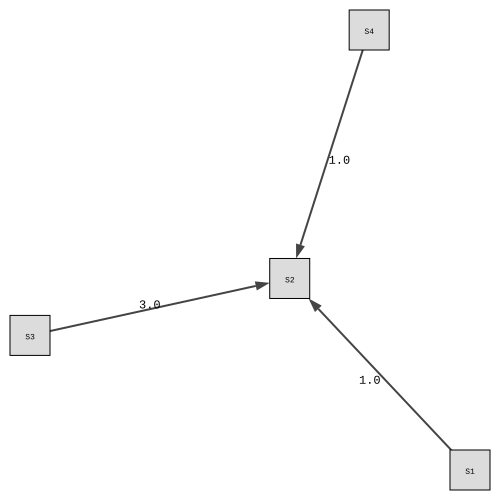

In [ ]:
plotname="graph_TKE_non_linear.pdf"
feature_names=['S1', 'S2', 'S3', 'S4']
W_est_tke_1 = np.around(syn_non,0)
adja_mat_tke = W_est_tke_1.tolist()

is_empty_graph=np.sum(np.abs(adja_mat_tke))==0

gr=igraph.Graph.Weighted_Adjacency(adja_mat_tke, mode="directed", attr="weight", loops=False)
gr.vs["name"]=feature_names
layout = gr.layout_kamada_kawai()

visual_style = {}
visual_style["vertex_size"] = 40
visual_style["vertex_label_size"]=8
visual_style["vertex_color"] = [220,220,220]
visual_style["vertex_shape"] = "rectangle"
visual_style["vertex_label"] = gr.vs["name"]
if not is_empty_graph:
  visual_style["edge_label"] =gr.es["weight"]
visual_style["edge_width"] = 2
visual_style["layout"] = layout
visual_style["bbox"] = (500, 500)
visual_style["margin"] = 30
igraph.plot(gr,plotname,**visual_style)

In [ ]:
np.savetxt('/content/notears-summary-adj-mat-D2.csv', syn_non, delimiter=",")

In [ ]:
W_est_TKE_non_1 = np.around(syn_non,0)
W_est_TKE_non_1[W_est_TKE_non_1 > 1] = 1
W_est_TKE_non_1

array([[0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [ ]:
cdt.metrics.SHD(true_graph, W_est_TKE_non_1)

7.0

In [ ]:
true_values = true_graph
predictions = W_est_TKE_non_1

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.5625, Precision: 0.3333333333333333, Recall: 0.16666666666666666, FDR: 0.6666666666666666, F1 Score: 0.2222222222222222


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_graph.reshape(-1), W_est_TKE_non_1.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_graph.reshape(-1), W_est_TKE_non_1.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_graph.reshape(-1), W_est_TKE_non_1.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_graph.reshape(-1), W_est_TKE_non_1.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.5625
Precision: 0.3333333333333333
Recall (Sensitivity): 0.16666666666666666
F1-Score: 0.2222222222222222


## Full Causal Graph

In [ ]:
syn_data_1d_nn.shape

(99995, 24)

In [ ]:
print(syn_data_1d_nn.dtype)

float64


In [ ]:
syn_data_1d_nn_32 = np.float32(syn_data_1d_nn)

In [ ]:
d = 24
model_full = NotearsMLP(dims=[d, 10, 1], bias=True)
syn_non_full = notears_nonlinear(model_full, syn_data_1d_nn_32)
syn_non_full

overflow encountered in matmul
overflow encountered in reduce


array([[ 0.        ,  0.        ,  0.        ,  1.5069574 ,  0.        ,
        44.95306   ,  1.8575081 ,  2.0482788 ,  0.54187363,  0.83657235,
         0.        ,  0.        ,  0.31977764,  1.4453479 ,  0.        ,
         0.        ,  0.        ,  0.7344216 ,  0.        ,  0.        ,
        10.531065  ,  1.1231492 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  2.601055  ,  1.4884794 ,  0.75248605,
         0.73005944,  0.        ,  0.        ,  0.        ,  0.6186711 ,
         0.        ,  0.        ,  0.        ,  0.67624635,  0.        ,
         0.        ,  0.99530095,  0.74045855,  0.        ,  0.        ,
         0.        ,  0.5644328 ,  0.43023166,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.1319078 ,  0.44812807,
         1.3322688 ,  0.        ,  1.7522486 ,  0.4578159 ,  1.3285911 ,
         0.        ,  0.42185152,  0.        ,  2.2062118 ,  0.        ,
         0.        ,  0.7594538 ,  0.9264291 ,  0.        ,  0.        ,
  

In [ ]:
np.savetxt('/content/notears-full-adj-mat-D2-all.csv', syn_non_full, delimiter=",")

In [ ]:
matrix_2d_2d_notears = syn_non_full[:,20:]

In [ ]:
np.savetxt('/content/notears-full-adj-mat-D2.csv', matrix_2d_2d_notears, delimiter=",")

In [ ]:
import networkx as nx
G_2d_s = nx.DiGraph()

nodes_2d_s = ["S1(t-5)", "S2(t-5)", "S3(t-5)",  "S4(t-5)",
         "S1(t-4)", "S2(t-4)", "S3(t-4)",  "S4(t-4)",
         "S1(t-3)", "S2(t-3)", "S3(t-3)",  "S4(t-3)",
         "S1(t-2)", "S2(t-2)", "S3(t-2)",  "S4(t-2)",
         "S1(t-1)", "S2(t-1)", "S3(t-1)",  "S4(t-1)",
         "S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
nodes_r_2d_s=["S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
pred_graph_f = np.zeros((4,24))

In [ ]:
for i in range (0, 24):
  G_2d_s.add_node(nodes_2d_s[i],pos=(int(i/4)+1,(i%4)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d_notears[i,j] > 0.3:
      print(i,j)
      G_2d_s.add_edge(nodes_2d_s[i], nodes_r_2d_s[j], weight=i)
      pred_graph_f[j,i]=1


0 0
0 1
1 1
1 2
2 1
3 1
4 1
6 0
6 1
6 3
7 1
7 3
8 1
8 3
10 1
11 1
12 0
12 1
14 1
14 3
15 1
16 1
16 2
16 3
18 0
18 1
18 3
19 1
19 3
22 1
23 1


In [ ]:
pos_2d_s=nx.get_node_attributes(G_2d_s,'pos')
pos_2d_s

{'S1(t-5)': (1, 1),
 'S2(t-5)': (1, 2),
 'S3(t-5)': (1, 3),
 'S4(t-5)': (1, 4),
 'S1(t-4)': (2, 1),
 'S2(t-4)': (2, 2),
 'S3(t-4)': (2, 3),
 'S4(t-4)': (2, 4),
 'S1(t-3)': (3, 1),
 'S2(t-3)': (3, 2),
 'S3(t-3)': (3, 3),
 'S4(t-3)': (3, 4),
 'S1(t-2)': (4, 1),
 'S2(t-2)': (4, 2),
 'S3(t-2)': (4, 3),
 'S4(t-2)': (4, 4),
 'S1(t-1)': (5, 1),
 'S2(t-1)': (5, 2),
 'S3(t-1)': (5, 3),
 'S4(t-1)': (5, 4),
 'S1(t)': (6, 1),
 'S2(t)': (6, 2),
 'S3(t)': (6, 3),
 'S4(t)': (6, 4)}

In [ ]:
weights_2d_s = nx.get_edge_attributes(G_2d_s,'weight').values()

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


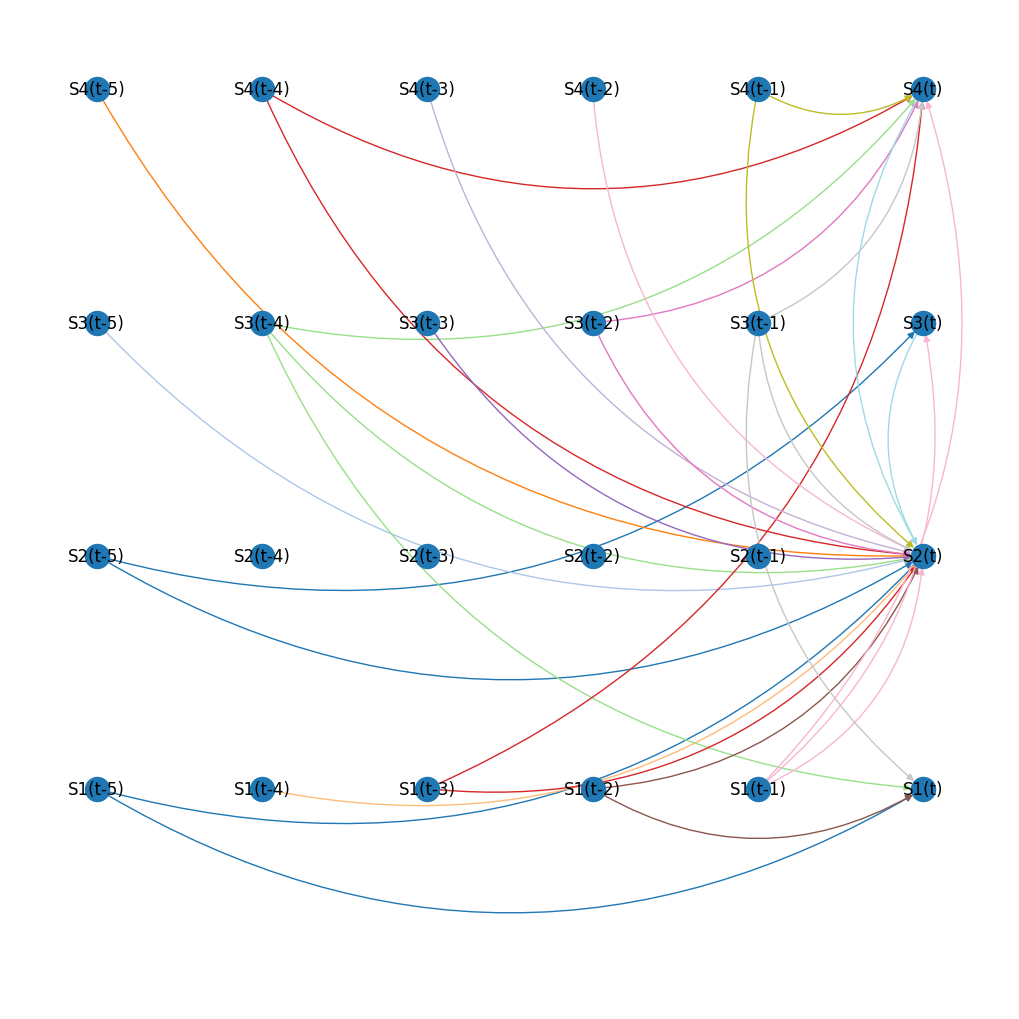

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
nx.draw(G_2d_s, pos_2d_s, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_2d_s, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

In [ ]:
syn_non_full_1 = np.around(syn_non_full,0)
syn_non_full_1[syn_non_full_1 > 1] = 1
syn_non_full_1

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [ ]:
cdt.metrics.SHD(true_full_graph, pred_graph_f)

24.0

In [ ]:
true_values = true_full_graph
predictions = pred_graph_f

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.75, Precision: 0.22580645161290322, Recall: 1.0, FDR: 0.7741935483870968, F1 Score: 0.3684210526315789


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.75
Precision: 0.22580645161290322
Recall (Sensitivity): 1.0
F1-Score: 0.3684210526315789


# DYNOTEARS Method


The DYNOTEARS method is already available inside the "CausalNex" library. So have installed that library to use this method on our synthetic dataset.

In [ ]:
%cd /content

/content


In [ ]:
%pwd

'/content'

In [ ]:
!pip install causalnex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.2/809.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Thi

In [ ]:
from causalnex.structure.dynotears import from_pandas_dynamic

sm = from_pandas_dynamic(syn_data_4_df, p=5, w_threshold=0.03, lambda_w=0.01, lambda_a=0.01)

In [ ]:
sm.to_directed()

In [ ]:
sm.pred

AdjacencyView({'S1_lag0': {'S3_lag2': {'origin': 'learned', 'weight': 0.19758343955843835}, 'S1_lag3': {'origin': 'learned', 'weight': 0.18614652140800794}, 'S3_lag3': {'origin': 'learned', 'weight': 0.2925877040602643}}, 'S1_lag1': {}, 'S1_lag2': {}, 'S1_lag3': {}, 'S1_lag4': {}, 'S1_lag5': {}, 'S2_lag0': {'S1_lag1': {'origin': 'learned', 'weight': 0.1656551371570293}, 'S2_lag1': {'origin': 'learned', 'weight': 0.047801656940285694}, 'S3_lag1': {'origin': 'learned', 'weight': 0.07124251246618793}, 'S2_lag2': {'origin': 'learned', 'weight': 0.05316564255593306}, 'S3_lag2': {'origin': 'learned', 'weight': 0.16333223767022548}, 'S2_lag3': {'origin': 'learned', 'weight': 0.051857866510573974}, 'S3_lag3': {'origin': 'learned', 'weight': 0.10625797718513806}, 'S2_lag4': {'origin': 'learned', 'weight': 0.0443607702165643}, 'S3_lag4': {'origin': 'learned', 'weight': 0.0695162607057888}, 'S2_lag5': {'origin': 'learned', 'weight': 0.05993029879797991}, 'S3_lag5': {'origin': 'learned', 'weight':

In [ ]:
sm.nodes

NodeView(('S1_lag0', 'S1_lag1', 'S1_lag2', 'S1_lag3', 'S1_lag4', 'S1_lag5', 'S2_lag0', 'S2_lag1', 'S2_lag2', 'S2_lag3', 'S2_lag4', 'S2_lag5', 'S3_lag0', 'S3_lag1', 'S3_lag2', 'S3_lag3', 'S3_lag4', 'S3_lag5', 'S4_lag0', 'S4_lag1', 'S4_lag2', 'S4_lag3', 'S4_lag4', 'S4_lag5'))

In [ ]:
sm.edges

OutEdgeView([('S1_lag1', 'S2_lag0'), ('S1_lag1', 'S3_lag0'), ('S1_lag3', 'S1_lag0'), ('S2_lag1', 'S2_lag0'), ('S2_lag1', 'S3_lag0'), ('S2_lag2', 'S2_lag0'), ('S2_lag2', 'S3_lag0'), ('S2_lag3', 'S2_lag0'), ('S2_lag3', 'S3_lag0'), ('S2_lag4', 'S2_lag0'), ('S2_lag4', 'S3_lag0'), ('S2_lag5', 'S2_lag0'), ('S2_lag5', 'S3_lag0'), ('S3_lag0', 'S4_lag0'), ('S3_lag1', 'S2_lag0'), ('S3_lag1', 'S3_lag0'), ('S3_lag1', 'S4_lag0'), ('S3_lag2', 'S1_lag0'), ('S3_lag2', 'S2_lag0'), ('S3_lag3', 'S1_lag0'), ('S3_lag3', 'S2_lag0'), ('S3_lag3', 'S3_lag0'), ('S3_lag3', 'S4_lag0'), ('S3_lag4', 'S2_lag0'), ('S3_lag4', 'S3_lag0'), ('S3_lag4', 'S4_lag0'), ('S3_lag5', 'S2_lag0')])

In [ ]:
nodes_2d_dy = ['S1_lag5', 'S2_lag5', 'S3_lag5',  'S4_lag5',
         'S1_lag4', 'S2_lag4', 'S3_lag4',  'S4_lag4',
         'S1_lag3', 'S2_lag3', 'S3_lag3',  'S4_lag3',
         'S1_lag2', 'S2_lag2', 'S3_lag2',  'S4_lag2',
         'S1_lag1', 'S2_lag1', 'S3_lag1',  'S4_lag1',
         'S1_lag0', 'S2_lag0', 'S3_lag0',  'S4_lag0']
nodes_r_2d_dy=['S1_lag0', 'S2_lag0', 'S3_lag0',  'S4_lag0']
pred_graph_full = np.zeros((4,24))

##Full Causal Graph

DYNOTEARS method generates the causal graph in a different format. So we have transformed their graph format into an array-like adjacency matrix.

In [ ]:
for ce in sm.edges:
  c = ce[0]
  e = ce[1]
  row = np.where(np.char.equal(nodes_r_2d_dy, e))[0]
  col = np.where(np.char.equal(nodes_2d_dy, c))[0]
  pred_graph_full[row, col]=1

In [ ]:
pred_graph_full

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
        1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0.]])

In [ ]:
np.savetxt('/content/dynotears-full-adj-mat-D2.csv', pred_graph_full, delimiter=",")

In [ ]:
import networkx as nx
G_2d_s = nx.DiGraph()

nodes_2d_s = ["S1(t-5)", "S2(t-5)", "S3(t-5)",  "S4(t-5)",
         "S1(t-4)", "S2(t-4)", "S3(t-4)",  "S4(t-4)",
         "S1(t-3)", "S2(t-3)", "S3(t-3)",  "S4(t-3)",
         "S1(t-2)", "S2(t-2)", "S3(t-2)",  "S4(t-2)",
         "S1(t-1)", "S2(t-1)", "S3(t-1)",  "S4(t-1)",
         "S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
nodes_r_2d_s=["S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
matrix_2d_2d_s = pred_graph_full

In [ ]:
for i in range (0, 24):
  G_2d_s.add_node(nodes_2d_s[i],pos=(int(i/4)+1,(i%4)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d_s[j,i] > 0.3:
      #print(i,j)
      G_2d_s.add_edge(nodes_2d_s[i], nodes_r_2d_s[j], weight=i)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


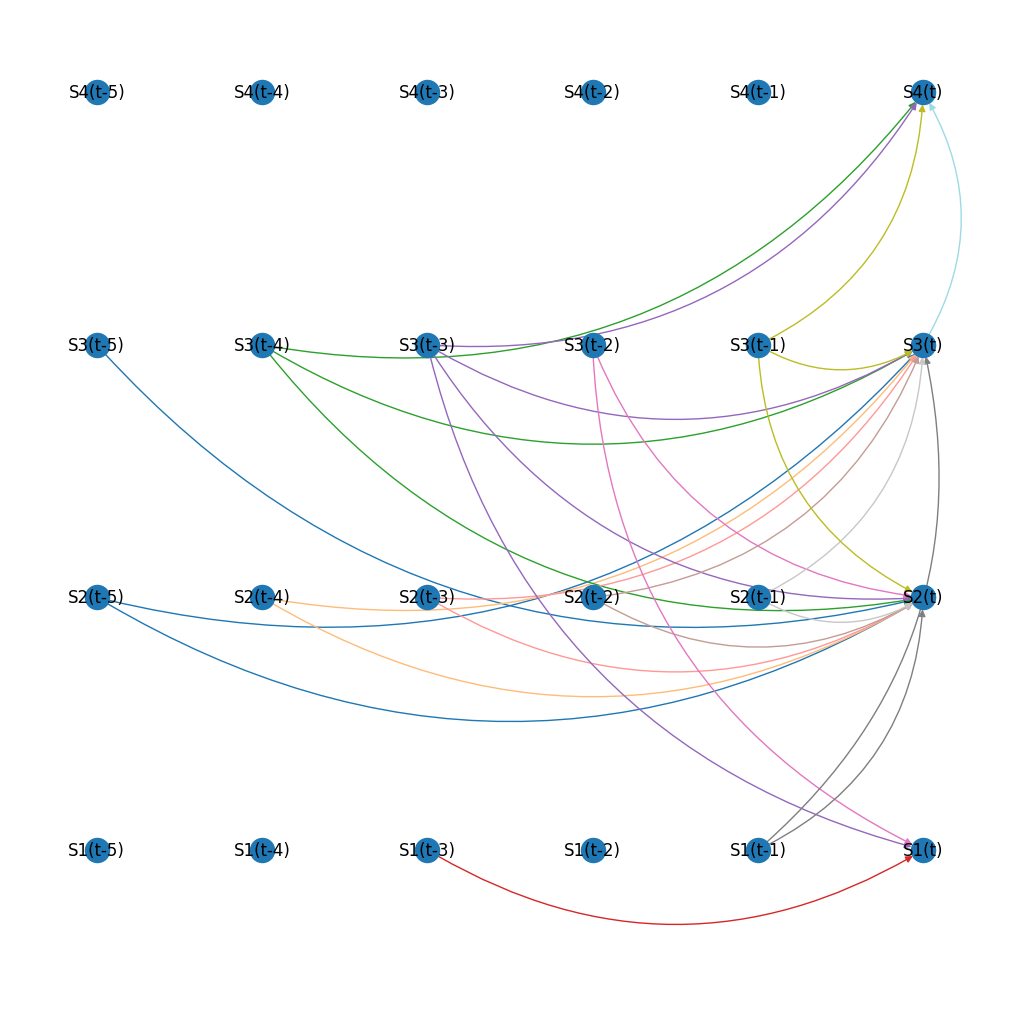

In [ ]:
pos_2d_s=nx.get_node_attributes(G_2d_s,'pos')
weights_2d_s = nx.get_edge_attributes(G_2d_s,'weight').values()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
nx.draw(G_2d_s, pos_2d_s, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_2d_s, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

In [ ]:
cdt.metrics.SHD(true_full_graph, pred_graph_full)

28.0

In [ ]:
true_values = true_full_graph
predictions = pred_graph_full

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.7083333333333334, Precision: 0.1111111111111111, Recall: 0.42857142857142855, FDR: 0.8888888888888888, F1 Score: 0.17647058823529413


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_full_graph.reshape(-1), pred_graph_full.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_full_graph.reshape(-1), pred_graph_full.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_full_graph.reshape(-1), pred_graph_full.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_full_graph.reshape(-1), pred_graph_full.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.7083333333333334
Precision: 0.1111111111111111
Recall (Sensitivity): 0.42857142857142855
F1-Score: 0.17647058823529413


##Summary Causal Graph

In [ ]:
import networkx as nx
G_2d_s1 = nx.DiGraph()

nodes_2d_s1 = ["S1", "S2", "S3",  "S4"]
nodes_r_2d_s1= ["S1", "S2", "S3",  "S4"]
edges_2d_s1 = []
pred_graph_s1 = np.zeros((4,4))

In [ ]:
for i in range (0, 4):
  G_2d_s1.add_node(nodes_2d_s1[i],pos=(int(i/2)+1,(i%2)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d_s[j,i] > 0.3:
      #print(i,j)
      G_2d_s1.add_edge(nodes_2d_s1[i%4], nodes_r_2d_s1[j], weight=i)
      pred_graph_s1[i%4, j]=1


In [ ]:
pos_2d_s1=nx.get_node_attributes(G_2d_s1,'pos')
pos_2d_s1

{'S1': (1, 1), 'S2': (1, 2), 'S3': (2, 1), 'S4': (2, 2)}

In [ ]:
weights_2d_s1 = nx.get_edge_attributes(G_2d_s1,'weight').values()

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


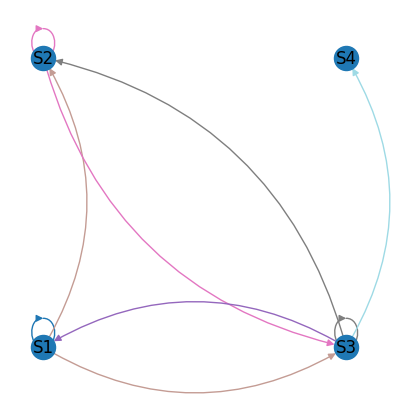

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
nx.draw(G_2d_s1, pos_2d_s1, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_2d_s1, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

In [ ]:
np.savetxt('/content/dynotears-summary-adj-mat-D2.csv', pred_graph_s1, delimiter=",")

In [ ]:
cdt.metrics.SHD(true_graph, pred_graph_s1)

7.0

In [ ]:
true_values = true_graph
predictions = pred_graph_s1

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.5625, Precision: 0.4444444444444444, Recall: 0.6666666666666666, FDR: 0.5555555555555556, F1 Score: 0.5333333333333333


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.5625
Precision: 0.4444444444444444
Recall (Sensitivity): 0.6666666666666666
F1-Score: 0.5333333333333333


In [ ]:
sm = from_pandas_dynamic(syn_data_4_df, p=5, w_threshold=0.01, lambda_w=0.01, lambda_a=0.01)

In [ ]:
sm.to_directed()

In [ ]:
from causalnex.plots import plot_structure
plot = plot_structure(sm)

In [ ]:
plot

<class 'pyvis.network.Network'> |N|=30 |E|=0

In [ ]:
plot.save_graph("syn_cd_plot.html")
from IPython.display import HTML
HTML(filename="syn_cd_plot.html")

#NTS-NOTEARS Model

To execute the NTS-NOTEARS method we have to install a new version of the Numpy package. The Numpy version by default available in Google Collab does not work with the NTS-NOTEARS method.

In [ ]:
%cd /content

/content


In [ ]:
!pip install lingam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 806.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 30.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
! git clone https://github.com/xiangyu-sun-789/NTS-NOTEARS

Cloning into 'NTS-NOTEARS'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 39 (delta 17), reused 32 (delta 13), pack-reused 0
Receiving objects: 100% (39/39), 26.69 KiB | 1.67 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [ ]:
%cd /content/NTS-NOTEARS/notears

/content/NTS-NOTEARS/notears


In [ ]:
from locally_connected import LocallyConnected
from lbfgsb_scipy import LBFGSBScipy
from trace_expm import trace_expm
from utils import *

In [ ]:
import csv
import math
import os
import warnings
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn import preprocessing
from locally_connected import LocallyConnected
from lbfgsb_scipy import LBFGSBScipy
from trace_expm import trace_expm
from utils import *


class NTS_NOTEARS(nn.Module):
    def __init__(self, dims, bias=True, number_of_lags=None, prior_knowledge=None, variable_names_no_time=None):
        super(NTS_NOTEARS, self).__init__()
        assert len(dims) >= 2
        assert dims[-1] == 1

        # the time steps (..., t-2, t-1, t) are ordered from left to right
        self.simultaneous_idx = self.number_of_lags = number_of_lags

        # k: lagged time steps + instantaneous step
        self.kernal_size = number_of_lags + 1

        self.prior_knowledge = prior_knowledge
        self.variable_names_no_time = variable_names_no_time

        d = dims[0]
        self.dims = dims

        # fc1: variable splitting for l1

        self.conv1d_pos = nn.Conv1d(in_channels=d, out_channels=d * dims[1], bias=bias, kernel_size=self.kernal_size,
                                    stride=1, padding=0)

        self.conv1d_neg = nn.Conv1d(in_channels=d, out_channels=d * dims[1], bias=bias, kernel_size=self.kernal_size,
                                    stride=1, padding=0)

        # L-BFGS-B algorithm for bound constrained minimization.
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#id11
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html#scipy.optimize.fmin_l_bfgs_b

        # in order to add prior knowledge rather than 0, we need asymmetric bounds on pos_weights and neg_weights.
        # It can be either (pos_weights>0 and neg_weights=0) or (pos_weights=0 and neg_weights>0)
        self.conv1d_pos.instantaneous_bounds = self._instantaneous_bounds_pos()
        self.conv1d_neg.instantaneous_bounds = self._instantaneous_bounds_neg()

        self.conv1d_pos.lag_bounds_lists = self._lag_bounds_pos()
        self.conv1d_neg.lag_bounds_lists = self._lag_bounds_neg()

        # fc2: local linear layers
        layers = []
        for l in range(len(dims) - 2):
            layers.append(LocallyConnected(d, dims[l + 1], dims[l + 2], bias=bias))
        self.fc2 = nn.ModuleList(layers)

    def _instantaneous_bounds_pos(self):
        d = self.dims[0]
        bounds = []
        for j in range(d):  # child nodes
            for m in range(self.dims[1]):
                for i in range(d):  # parent nodes
                    if i == j:  # no self loop
                        bound = (0, 0)

                    else:
                        bound = (0, None)

                    # overwrite the bound if prior knowledge is provided
                    if self.prior_knowledge is not None:
                        for pk in self.prior_knowledge:
                            if pk["from_lag"] == 0:
                                if (self.variable_names_no_time[i] == pk["from_node"] or pk["from_node"] == "*") and \
                                        (self.variable_names_no_time[j] == pk["to_node"] or pk["to_node"] == "*"):
                                    lower_bound_converted = convert_provided_bound(pk["lower_bound"], self.dims[1])
                                    upper_bound_converted = \
                                        convert_provided_bound(pk["upper_bound"], self.dims[1]) \
                                            if pk["upper_bound"] is not None \
                                            else None
                                    bound = (lower_bound_converted, upper_bound_converted)

                    bounds.append(bound)
        return bounds

    def _instantaneous_bounds_neg(self):
        d = self.dims[0]
        bounds = []
        for j in range(d):  # child nodes
            for m in range(self.dims[1]):
                for i in range(d):  # parent nodes
                    if i == j:  # no self loop
                        bound = (0, 0)

                    else:
                        bound = (0, None)

                    # overwrite the neg bound as (0, 0) if prior knowledge is provided
                    if self.prior_knowledge is not None:
                        for pk in self.prior_knowledge:
                            if pk["from_lag"] == 0:
                                if (self.variable_names_no_time[i] == pk["from_node"] or pk["from_node"] == "*") and \
                                        (self.variable_names_no_time[j] == pk["to_node"] or pk["to_node"] == "*"):
                                    bound = (0, 0)

                    bounds.append(bound)
        return bounds

    def _lag_bounds_pos(self):
        d = self.dims[0]
        bounds = []
        for j in range(d):  # child nodes
            for m in range(self.dims[1]):
                for i in range(d):  # parent nodes
                    bound = []
                    for lag in range(self.number_of_lags, 0, -1):  # lags
                        current_bound = [(0, None)]

                        # overwrite the bound if prior knowledge is provided
                        if self.prior_knowledge is not None:
                            for pk in self.prior_knowledge:
                                if pk["from_lag"] == lag:
                                    if (self.variable_names_no_time[i] == pk["from_node"] or pk["from_node"] == "*") and \
                                            (self.variable_names_no_time[j] == pk["to_node"] or pk["to_node"] == "*"):
                                        lower_bound_converted = convert_provided_bound(pk["lower_bound"], self.dims[1])
                                        upper_bound_converted = \
                                            convert_provided_bound(pk["upper_bound"], self.dims[1]) \
                                                if pk["upper_bound"] is not None \
                                                else None
                                        current_bound = [(lower_bound_converted, upper_bound_converted)]

                        bound += current_bound

                    bounds.append(bound)
        return bounds

    def _lag_bounds_neg(self):
        d = self.dims[0]
        bounds = []
        for j in range(d):  # child nodes
            for m in range(self.dims[1]):
                for i in range(d):  # parent nodes
                    bound = []
                    for lag in range(self.number_of_lags, 0, -1):  # lags
                        current_bound = [(0, None)]

                        # overwrite the neg bound as (0, 0) if prior knowledge is provided
                        if self.prior_knowledge is not None:
                            for pk in self.prior_knowledge:
                                if pk["from_lag"] == lag:
                                    if (self.variable_names_no_time[i] == pk["from_node"] or pk["from_node"] == "*") and \
                                            (self.variable_names_no_time[j] == pk["to_node"] or pk["to_node"] == "*"):
                                        current_bound = [(0, 0)]

                        bound += current_bound

                    bounds.append(bound)
        return bounds

    def forward(self, x_series, device):
        """
        d: the number of variables per time step.

        n: the number of time steps in the data.

        k: the number of time steps in the model (lag + instantaneous)

        :param x_series: shape [1, d, n]
        :param device:
        :return: shape [n, d]
        """

        x_not_shaped = self.conv1d_pos.to(device)(x_series) - self.conv1d_neg.to(device)(x_series)  # [1, d * m1, n]

        x = x_not_shaped.T  # [n, d * m1, 1]
        x = x.squeeze(dim=2)  # [n, d * m1]

        x = x.view(-1, self.dims[0], self.dims[1])  # [n, d, m1]

        assert x.size()[1] == self.dims[0] and x.size()[2] == self.dims[1]

        # assert torch.all(torch.eq(x_not_shaped[0, 0:self.dims[1], 0], x[0, 0, :]))
        # assert torch.all(torch.eq(x_not_shaped[0, self.dims[1]:self.dims[1] + self.dims[1], 0], x[0, 1, :]))
        # assert torch.all(torch.eq(x_not_shaped[0, 0:self.dims[1], 1], x[1, 0, :]))
        # assert torch.all(torch.eq(x_not_shaped[0, self.dims[1]:self.dims[1] + self.dims[1], 1], x[1, 1, :]))

        for fc in self.fc2.to(device):
            x = torch.sigmoid(x)  # [n, d, m1]
            x = fc(x)  # [n, d, m2]
        x = x.squeeze(dim=2)  # [n, d]
        return x

    def h_func(self):
        """Constrain 2-norm-squared of fc1 weights along m1 dim to be a DAG"""

        """
        compute the h(W) surrogate function. This is only needed for the instantaneous weights, not for the lagged weights.
        """

        d = self.dims[0]

        # [:,:,0:k-1] are lagged, [:,:,k-1] are instantaneous
        fc_simultaneous_weight = self.conv1d_pos.weight[:, :, self.simultaneous_idx] - self.conv1d_neg.weight[:, :,
                                                                                       self.simultaneous_idx]  # [j * m1, i]
        fc_simultaneous_weight = fc_simultaneous_weight.view(d, -1, d)  # [j, m1, i]
        A = torch.sum(fc_simultaneous_weight * fc_simultaneous_weight, dim=1).t()  # [i, j]

        A = A.cpu()  # required inside `trace_expm()`

        h = trace_expm(A) - d  # (Zheng et al. 2018)
        # A different formulation, slightly faster at the cost of numerical stability
        # M = torch.eye(d) + A / d  # (Yu et al. 2019)
        # E = torch.matrix_power(M, d - 1)
        # h = (E.t() * M).sum() - d
        return h

    def l2_reg(self):
        """Take 2-norm-squared of all parameters"""
        reg = 0.

        fc1_weight = self.conv1d_pos.weight - self.conv1d_neg.weight  # [j * m1, i]
        reg += torch.sum(fc1_weight ** 2)

        for fc in self.fc2:
            reg += torch.sum(fc.weight ** 2)
        return reg

    def fc1_l1_reg(self, kernel_index=None):
        """
        Take l1 norm of input weights, both lagged and instantaneous
        """
        if kernel_index is None:
            reg = torch.sum(self.conv1d_pos.weight + self.conv1d_neg.weight)
        else:
            reg = torch.sum(self.conv1d_pos.weight[:, :, kernel_index] + self.conv1d_neg.weight[:, :, kernel_index])

        return reg

    @torch.no_grad()
    def fc1_to_adj(self):
        """Get W from fc1 weights, take 2-norm over m1 dim"""
        d = self.dims[0]

        # [:,:,0:k-1] are lagged, [:,:,k-1] are instantaneous
        fc_simultaneous_weight = self.conv1d_pos.weight[:, :, self.simultaneous_idx] - self.conv1d_neg.weight[:, :,
                                                                                       self.simultaneous_idx]  # [j * m1, i]
        fc_simultaneous_weight = fc_simultaneous_weight.view(d, -1, d)  # [j, m1, i]
        A_simultaneous = torch.sum(fc_simultaneous_weight * fc_simultaneous_weight, dim=1).t()  # [i, j]
        W_simultaneous = torch.sqrt(A_simultaneous)  # [i, j]
        W_simultaneous = W_simultaneous.cpu().detach().numpy()  # [i, j]

        W_NAR = np.empty((0, self.dims[0]))  # [0, j], will be [(k-1) * i, j]
        for lag_idx in range(self.number_of_lags):
            fc_NAR_weight = self.conv1d_pos.weight[:, :, lag_idx] - self.conv1d_neg.weight[:, :, lag_idx]  # [j * m1, i]
            fc_NAR_weight = fc_NAR_weight.view(d, -1, d)  # [j, m1, i]
            A_NAR = torch.sum(fc_NAR_weight * fc_NAR_weight, dim=1).t()  # [i, j]
            W_current_lag = torch.sqrt(A_NAR)  # [i, j]
            W_current_lag = W_current_lag.cpu().detach().numpy()  # [i, j]

            W_NAR = np.vstack((W_NAR, W_current_lag))

            # make sure earlier lags are stacked above later lags
            # assert np.all(W_NAR[-1 * self.dims[0]:, :] == W_current_lag)

        assert W_NAR.shape == (self.dims[0] * self.number_of_lags, self.dims[0])

        return W_simultaneous, W_NAR


def convert_provided_bound(bound_provided_by_user, number_of_hidden_neurons_connected):
    """
    for either the lower bound or the upper bound provided by the user, it is not the final estimated edge strength
    `s`, because the final estimated edge strength $$ s = L2-norm(all relevant edges) = sqrt(m * b^2) $$, where `s` is the
    estimated edge strength shown on the graph, `b` is the provided bound by the user, and `m` is the number of hidden
    neurons connected. In order to make the estimated edge strength `s` equal to the provided bound `b`, we need to
    scale the provided bound `b` behind the scenes.

    s = b = sqrt(m * x^2), where x is the scaled version of `b` provided by the user.

    Therefore, x = sqrt(b^2/m), which we apply to the L-BFGS-B algorithm as the bound.

    """
    return math.sqrt(bound_provided_by_user ** 2 / number_of_hidden_neurons_connected)


def squared_loss(output, target):
    n = target.shape[0]
    loss = 0.5 / n * torch.sum((output - target) ** 2)
    return loss


def reshape_for_model_forward(X, model):
    X_reshaped = X.T.reshape(1, model.dims[0], -1)
    return X_reshaped


def dual_ascent_step(model: NTS_NOTEARS, normalized_X, device, lambda1, lambda2, rho, alpha, h, rho_max):
    """Perform one step of dual ascent in augmented Lagrangian."""
    h_new = None
    optimizer = LBFGSBScipy(model.parameters())
    optimizer.assign_bounds(model)

    while rho < rho_max:
        def closure():
            optimizer.zero_grad()

            assert X_torch.shape[0] == 1
            assert X_torch.shape[1] == model.dims[0]

            X_hat = model(X_torch, device)

            # assert torch.all(
            #     torch.eq(X_torch[0, :, model.simultaneous_idx],
            #              torch.squeeze(X_torch.T)[model.simultaneous_idx:][0, :]))
            # assert torch.all(torch.eq(X_torch[0, :, model.simultaneous_idx + 1],
            #                           torch.squeeze(X_torch.T)[model.simultaneous_idx:][1, :]))
            # assert X_hat.size() == torch.squeeze(X_torch.T)[model.simultaneous_idx:].size()

            loss = squared_loss(X_hat,
                                torch.squeeze(X_torch.T)[
                                model.simultaneous_idx:])  # compare the instantaneous time step

            h_val = model.h_func()
            penalty = 0.5 * rho * h_val * h_val + alpha * h_val
            l2_reg = 0.5 * lambda2 * model.l2_reg()

            # apply each lambda1 to its corresponding kernel step
            if type(lambda1) == list:
                if len(lambda1) != model.kernal_size:
                    raise Exception(
                        "Lambda1s need to be defined for all steps. In the order of ..., lag2, lag1, instantaneous.")

                l1_reg = 0
                for kernel_index in range(model.kernal_size):
                    current_lambda1 = lambda1[kernel_index]
                    l1_reg += current_lambda1 * model.fc1_l1_reg(kernel_index)

            # apply the lambda1 to all kernel steps
            else:
                l1_reg = lambda1 * model.fc1_l1_reg()

            primal_obj = loss + penalty + l2_reg + l1_reg
            primal_obj.backward()
            return primal_obj

        normalized_X_reshaped = reshape_for_model_forward(normalized_X, model)

        # assert np.all(normalized_X[0, :] == normalized_X_reshaped[0, :, 0])
        # assert np.all(normalized_X[1, :] == normalized_X_reshaped[0, :, 1])

        X_torch = torch.from_numpy(normalized_X_reshaped).to(device)

        optimizer.step(closure)  # NOTE: updates model in-place

        # make sure bounds are working correctly
        # model.conv1d_pos.weight shape: (d * m1, d, k)
        # assert torch.all(model.conv1d_pos.weight[0:model.dims[1], 0, model.simultaneous_idx] == 0)
        # assert torch.all(model.conv1d_pos.weight[model.dims[1]:model.dims[1] * 2, 1, model.simultaneous_idx] == 0)
        # assert torch.all(model.conv1d_neg.weight[0:model.dims[1], 0, model.simultaneous_idx] == 0)
        # assert torch.all(model.conv1d_neg.weight[model.dims[1]:model.dims[1] * 2, 1, model.simultaneous_idx] == 0)

        with torch.no_grad():
            h_new = model.h_func().item()
        if h_new > 0.25 * h:
            rho *= 10
        else:
            break
    alpha += rho * h_new
    return rho, alpha, h_new


def train_NTS_NOTEARS(model: NTS_NOTEARS,
                      normalized_X,
                      device,
                      # float: The lambda applies to all convolutional parameters in all time steps.
                      # list: A list of lambdas for convolutional parameters in each time step. In the order of ..., lag2, lag1, instantaneous. E.g. [0.02, 0.01]
                      lambda1: float or list,
                      lambda2: float,  # The lambda for all parameters.
                      # float: The w_threshold applies to all convolutional parameters in all time steps.
                      # list: A list of w_thresholds for convolutional parameters in each time step. In the order of ..., lag2, lag1, instantaneous. E.g. [0.3, 0.3]
                      w_threshold: float or list,
                      max_iter: int = 100,
                      # in order to avoid cycles in the estimated graph, decrease the value here.
                      h_tol: float = 1e-8,
                      rho_max: float = 1e+16,
                      verbose=0):
    rho, alpha, h = 1.0, 0.0, np.inf
    for iteration in range(max_iter):
        if verbose > 0:
            print('\niteration: ', iteration)

        rho, alpha, h = dual_ascent_step(model, normalized_X, device, lambda1, lambda2, rho, alpha, h, rho_max)
        if h <= h_tol:
            print("Done, h {:e} <= h_tol {:e}".format(h, h_tol))
            break

        if rho >= rho_max:
            warnings.warn("h {:e} > h_tol {:e} . "
                          "Consider to increase rho_max. "
                          "rho {:e} >= rho_max {:e}".format(h, h_tol, rho, rho_max))
            break

        if h > h_tol and iteration == max_iter - 1:
            warnings.warn("Failed to converge. Consider to increase max_iter.")

    # assert torch.all(model.conv1d_pos.weight[0:model.dims[1], 0, model.simultaneous_idx] == 0)
    # assert torch.all(model.conv1d_neg.weight[0:model.dims[1], 0, model.simultaneous_idx] == 0)
    # assert torch.all(model.conv1d_pos.weight[model.dims[1]:model.dims[1] * 2, 1, model.simultaneous_idx] == 0)
    # assert torch.all(model.conv1d_neg.weight[model.dims[1]:model.dims[1] * 2, 1, model.simultaneous_idx] == 0)

    W_simultaneous_est, W_NAR_est = model.fc1_to_adj()

    # eliminate edges smaller than `w_threshold`
    if type(w_threshold) == list:

        if len(w_threshold) != model.kernal_size:
            raise Exception(
                "w_thresholds need to be defined for all steps. In the order of ..., lag2, lag1, instantaneous.")

        # apply w_threshold to instantaneous step
        W_simultaneous_est[np.abs(W_simultaneous_est) < w_threshold[-1]] = 0

        # apply w_threshold to lagged steps in the order of ..., lag2, lag1.
        d = model.dims[0]
        for kernel_index in range(model.kernal_size - 1):
            W_NAR_est[d * kernel_index: d * (kernel_index + 1), :][
                np.abs(W_NAR_est[d * kernel_index: d * (kernel_index + 1), :]) < w_threshold[kernel_index]] = 0

    else:
        W_simultaneous_est[np.abs(W_simultaneous_est) < w_threshold] = 0
        W_NAR_est[np.abs(W_NAR_est) < w_threshold] = 0

    d = model.dims[0]
    k = model.kernal_size  # number of lags + 1

    W_est_full = np.zeros((d * k, d * k))  # shape: (d * k, d * k)

    # the W is defined as row variable -> column variable
    # for lagged W:
    #   row-wise: x1_{t-2}, x2_{t-2}, ..., x1_{t-1}, x2_{t-1}, ...,
    #   column-wise: x1_{t}, x2_{t}, ...
    # for instantaneous W:
    #   row-wise: x1_{t}, x2_{t}, ...
    #   column-wise: x1_{t}, x2_{t}, ...
    # therefore, stack W's vertically (lagged W first, instantaneous W last)
    W_est = np.vstack((W_NAR_est, W_simultaneous_est))  # shape: (d * k, d)

    W_est_full[:, -1 * d:] = W_est

    # `W_est_full` is defined as: row variable -> column variable
    # row variables and column variables are the same, in the order of:
    # ..., x1_{t-2}, x2_{t-2}, ..., x1_{t-1}, x2_{t-1}, ..., x1_{t}, x2_{t}, ...
    return W_est_full


In [ ]:
from utils import *
def main(lags=5, data= syn_data_4_df):
    torch.set_default_dtype(torch.double)
    np.set_printoptions(precision=3)

    sequence_length = 2000
    d = 5
    sem_type = 'AdditiveIndexModel'
    number_of_lags = lags #5
    result_folder = 'results'
    seed = 12345

    if not os.path.exists(result_folder):
        os.mkdir(result_folder)

    #import utils as ut
    set_random_seed(seed)

    n, s0, graph_type = sequence_length, d, 'ER'

    variable_names_no_time = ['X{}'.format(j) for j in range(1, d + 1)]
    variable_names = make_variable_names_with_time_steps(number_of_lags, variable_names_no_time)

    normalized_X = data
    #assert (normalized_X.std(axis=0).round(decimals=3) == 1).all()  # make sure all the variances are (very close to) 1

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('\nUsing device: {}\n'.format(device))

    w_threshold = 0.3

    prior_knowledge = None



    model = NTS_NOTEARS(dims=[d, 10, 1], bias=True, number_of_lags=number_of_lags,
                        prior_knowledge=prior_knowledge, variable_names_no_time=variable_names_no_time)

    W_est_full = train_NTS_NOTEARS(model, normalized_X, device=device, lambda1=0.005, lambda2=0.01,
                                   w_threshold=w_threshold, h_tol=1e-60, verbose=1)

    variable_names = make_variable_names_with_time_steps(number_of_lags, variable_names_no_time)
    print(variable_names)

    file_name = 'W_estimated_DAG'

    save_adjacency_matrix_in_csv(os.path.join(result_folder, file_name), W_est_full, variable_names)

    draw_DAGs_using_LINGAM(os.path.join(result_folder, file_name), W_est_full, variable_names)

    binary_estimated = W_est_full != 0

    total_d = d * (number_of_lags + 1)
    #draw_adjacency_matrix_colormap(B_true, total_d, "True Graph", result_folder)
    draw_adjacency_matrix_colormap(binary_estimated, total_d, "Estimated Graph", result_folder)

    #draw_adjacency_matrix_colormap(B_true[:d, -d:], d, "True (t-2)", result_folder)
    draw_adjacency_matrix_colormap(binary_estimated[:d, -d:], d, "Estimated (t-2)", result_folder)

    #draw_adjacency_matrix_colormap(B_true[d:2 * d, -d:], d, "True (t-1)", result_folder)
    draw_adjacency_matrix_colormap(binary_estimated[d:2 * d, -d:], d, "Estimated (t-1)", result_folder)

    #draw_adjacency_matrix_colormap(B_true[2 * d:, -d:], d, "True (t)", result_folder)
    draw_adjacency_matrix_colormap(binary_estimated[2 * d:, -d:], d, "Estimated (t)", result_folder)

    #draw_adjacency_matrix_colormap_with_variables(B_true, number_of_lags, d, "True Graph", result_folder,
                                                 # variable_names)
    draw_adjacency_matrix_colormap_with_variables(binary_estimated, number_of_lags, d, "Estimated Graph", result_folder,
                                                  variable_names)

    assert is_dag(W_est_full), 'The estimated graph has cycles.'

    #acc = ut.count_accuracy(B_true, W_est_full != 0)
    #print(acc)
    #write_log_file(os.path.join(result_folder, "SHD.txt"), str(acc))

With time lab 1 this model throws some error.

In [ ]:
main(lags=5, data= syn_data_4_df.to_numpy())


Using device: cpu


iteration:  0
Done, h 0.000000e+00 <= h_tol 1.000000e-60
['X1(t-5)', 'X2(t-5)', 'X3(t-5)', 'X4(t-5)', 'X1(t-4)', 'X2(t-4)', 'X3(t-4)', 'X4(t-4)', 'X1(t-3)', 'X2(t-3)', 'X3(t-3)', 'X4(t-3)', 'X1(t-2)', 'X2(t-2)', 'X3(t-2)', 'X4(t-2)', 'X1(t-1)', 'X2(t-1)', 'X3(t-1)', 'X4(t-1)', 'X1(t)', 'X2(t)', 'X3(t)', 'X4(t)']


/content/NTS-NOTEARS/notears/utils.py:213: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(variable_names[-d:], rotation=-90)
/content/NTS-NOTEARS/notears/utils.py:214: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(variable_names)


##Full Cusal Graph

The NTS-NOTEARS method stores the predicted causal graph inside the result directory of the installed packeage with the file name "W_estimated_DAG.csv". This method also generate the colormap of the predicted causal graph.

In [ ]:
mat_nts_notears = pd.read_csv('/content/NTS-NOTEARS/notears/results/W_estimated_DAG.csv')

In [ ]:
mat_nts_notears

,row->column,X1(t-5),X2(t-5),X3(t-5),X4(t-5),X1(t-4),X2(t-4),X3(t-4),X4(t-4),X1(t-3),...,X3(t-2),X4(t-2),X1(t-1),X2(t-1),X3(t-1),X4(t-1),X1(t),X2(t),X3(t),X4(t)
0,X1(t-5),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,X2(t-5),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,X3(t-5),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.328350,0.0
3,X4(t-5),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
4,X1(t-4),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
5,X2(t-4),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
6,X3(t-4),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.596083,0.0,0.000000,0.0
7,X4(t-4),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
8,X1(t-3),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
9,X2(t-3),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


In [ ]:
matrix_2d_2d_nts_notears = mat_nts_notears.to_numpy()[:,21:]

In [ ]:
np.savetxt('/content/nts-notears-full-adj-mat-D2.csv', matrix_2d_2d_nts_notears, delimiter=",")

In [ ]:
import networkx as nx
G_2d_s = nx.DiGraph()

nodes_2d_s = ["S1(t-5)", "S2(t-5)", "S3(t-5)",  "S4(t-5)",
         "S1(t-4)", "S2(t-4)", "S3(t-4)",  "S4(t-4)",
         "S1(t-3)", "S2(t-3)", "S3(t-3)",  "S4(t-3)",
         "S1(t-2)", "S2(t-2)", "S3(t-2)",  "S4(t-2)",
         "S1(t-1)", "S2(t-1)", "S3(t-1)",  "S4(t-1)",
         "S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
nodes_r_2d_s=["S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
pred_graph_f = np.zeros((4,24))

In [ ]:
for i in range (0, 24):
  G_2d_s.add_node(nodes_2d_s[i],pos=(int(i/4)+1,(i%4)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d_nts_notears[i,j] > 0.3:
      print(i,j)
      G_2d_s.add_edge(nodes_2d_s[i], nodes_r_2d_s[j], weight=i)
      pred_graph_f[j,i]=1


2 2
6 0
12 0
16 2
18 0
23 2


In [ ]:
pos_2d_s=nx.get_node_attributes(G_2d_s,'pos')
pos_2d_s

{'S1(t-5)': (1, 1),
 'S2(t-5)': (1, 2),
 'S3(t-5)': (1, 3),
 'S4(t-5)': (1, 4),
 'S1(t-4)': (2, 1),
 'S2(t-4)': (2, 2),
 'S3(t-4)': (2, 3),
 'S4(t-4)': (2, 4),
 'S1(t-3)': (3, 1),
 'S2(t-3)': (3, 2),
 'S3(t-3)': (3, 3),
 'S4(t-3)': (3, 4),
 'S1(t-2)': (4, 1),
 'S2(t-2)': (4, 2),
 'S3(t-2)': (4, 3),
 'S4(t-2)': (4, 4),
 'S1(t-1)': (5, 1),
 'S2(t-1)': (5, 2),
 'S3(t-1)': (5, 3),
 'S4(t-1)': (5, 4),
 'S1(t)': (6, 1),
 'S2(t)': (6, 2),
 'S3(t)': (6, 3),
 'S4(t)': (6, 4)}

In [ ]:
weights_2d_s = nx.get_edge_attributes(G_2d_s,'weight').values()

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


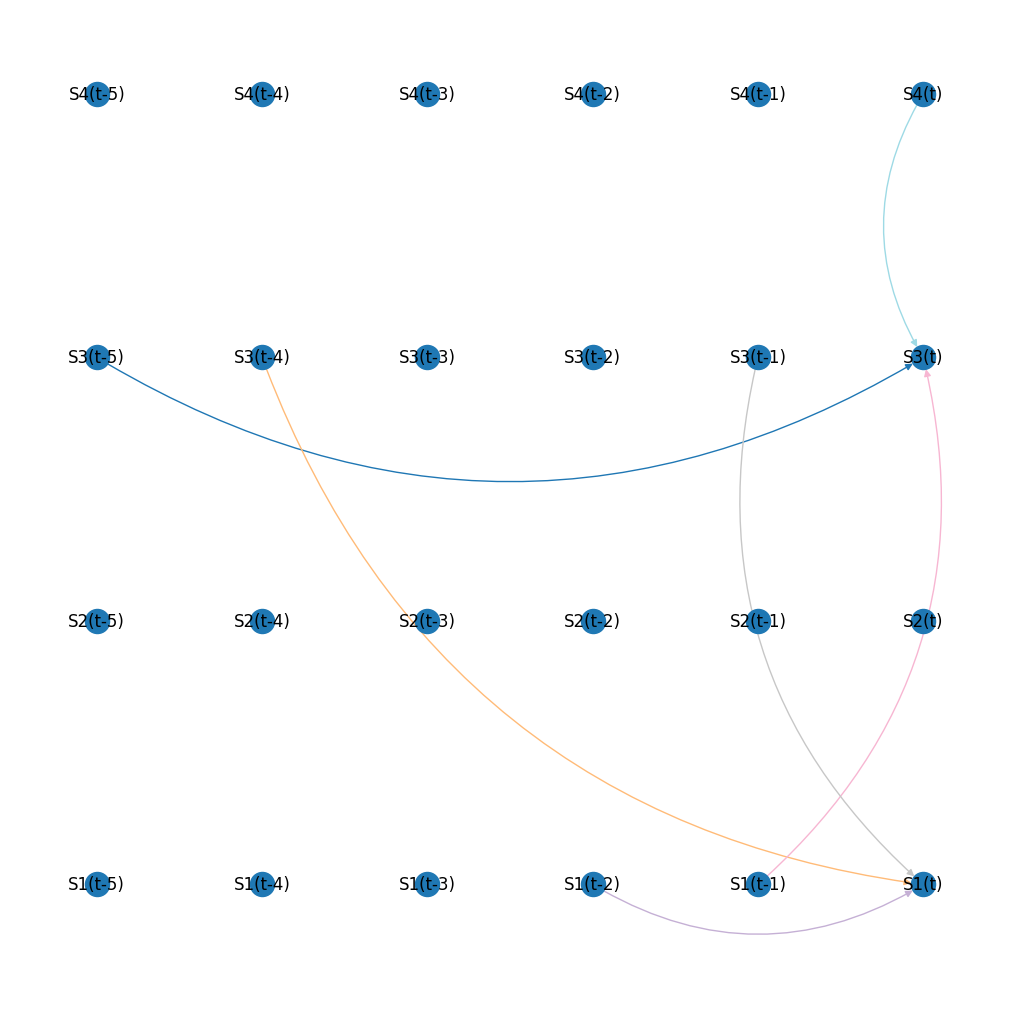

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
nx.draw(G_2d_s, pos_2d_s, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_2d_s, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

In [ ]:
pred_graph_f

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
cdt.metrics.SHD(true_full_graph, pred_graph_f)

9.0

In [ ]:
true_values = true_full_graph
predictions = pred_graph_f

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.90625, Precision: 0.3333333333333333, Recall: 0.2857142857142857, FDR: 0.6666666666666666, F1 Score: 0.30769230769230765


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.90625
Precision: 0.3333333333333333
Recall (Sensitivity): 0.2857142857142857
F1-Score: 0.30769230769230765


##Summary Causal Graph

In [ ]:
import networkx as nx
G_2d_s1 = nx.DiGraph()

nodes_2d_s1 = ["S1", "S2", "S3",  "S4"]
nodes_r_2d_s1= ["S1", "S2", "S3",  "S4"]
edges_2d_s1 = []
pred_graph_s1 = np.zeros((4,4))

In [ ]:
for i in range (0, 4):
  G_2d_s1.add_node(nodes_2d_s1[i],pos=(int(i/2)+1,(i%2)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d_nts_notears[i,j] > 0.3:
      #print(i,j)
      G_2d_s1.add_edge(nodes_2d_s1[i%4], nodes_r_2d_s1[j], weight=i)
      pred_graph_s1[i%4, j]=1


In [ ]:
pos_2d_s1=nx.get_node_attributes(G_2d_s1,'pos')
pos_2d_s1

{'S1': (1, 1), 'S2': (1, 2), 'S3': (2, 1), 'S4': (2, 2)}

In [ ]:
weights_2d_s1 = nx.get_edge_attributes(G_2d_s1,'weight').values()

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


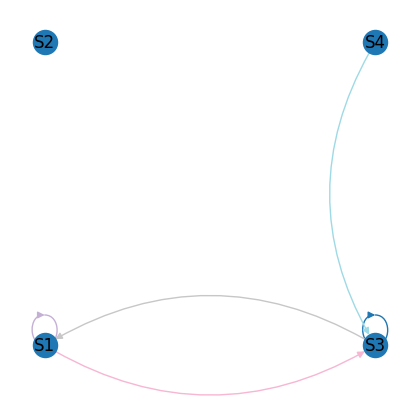

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
nx.draw(G_2d_s1, pos_2d_s1, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_2d_s1, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

In [ ]:
np.savetxt('/content/nts-notears-summary-adj-mat-D2.csv', pred_graph_s1, delimiter=",")

In [ ]:
cdt.metrics.SHD(true_graph, pred_graph_s1)

7.0

In [ ]:
true_values = true_graph
predictions = pred_graph_s1

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.5625, Precision: 0.4, Recall: 0.3333333333333333, FDR: 0.6, F1 Score: 0.3636363636363636


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.5625
Precision: 0.4
Recall (Sensitivity): 0.3333333333333333
F1-Score: 0.3636363636363636
